In [138]:
import numpy as np 
import pandas as pd
import csv
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
import random
import string
import json
from datetime import datetime

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# displays all columns and rows when asked to print
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Getting English tweets between time-period of interest and preprocess

In [152]:
# list of all the dataset files
dataset_paths = ["../datasets/russia_052020_tweets_csv_hashed_2.csv", 
         "../datasets/russian_linked_tweets_csv_hashed.csv", 
         "../datasets/ira_tweets_csv_hashed.csv", 
         "../datasets/russia_201906_1_tweets_csv_hashed.csv"]

# path to store the entire combined dataset
combined_dataset_path = "../datasets/russian_trolls.csv"

# returns a pandas dataframe consisting of entries from all the dataset files
def get_combined_dataset(paths):
    data = pd.concat((pd.read_csv(file) for file in paths))
    return data

# twitter_data = get_combined_dataset(dataset_paths)
# twitter_data.drop_duplicates(subset = 'tweetid', keep='first', inplace=True)
data = get_combined_dataset(dataset_paths)
print("Number of tweets in the combined dataset: ", data.shape[0])

def remove_url(tweet):
    result = re.sub(r"http\S+", "", tweet)
    return result

def remove_mentions(tweet):
    result = re.sub(r"@\S+", "", tweet)
    return result

def remove_retweet(tweet):
    result = re.sub(r"RT @\S+", "", tweet)
    return result

def remove_punctuations(tweet):
    result = tweet.translate(str.maketrans('', '', string.punctuation))
    return result

# takes list of tweets as input and returns list of pre-processed tweets as output
def preprocess(tweets):
    processed_tweets = []
    for tweet in tweets:
        result = remove_punctuations(remove_mentions(remove_retweet(remove_url(tweet))))
        processed_tweets.append(result)
    return processed_tweets

# Filtering data between 01.01.2019 to 01.07.2017
data['tweet_time'] = pd.to_datetime(data['tweet_time'], format = '%Y-%m-%d')
start_date = '2016-01-01'
end_date = '2017-07-01'
mask = (data['tweet_time'] > start_date) & (data['tweet_time'] <= end_date)
data = data.loc[mask]
print("Number of tweets in the dataset after filtering: ", data.shape[0])

# extracts just the english tweets by using the language tag
is_english_tweet = data['tweet_language'] == 'en'
f_english_data = data[is_english_tweet]
print("Number of English tweets in the filtered dataset: ", f_english_data.shape[0])
f_english_tweet_data = f_english_data[['tweetid', 'tweet_text', 'tweet_time']]

tweets = f_english_tweet_data['tweet_text']
tweets = preprocess(tweets)

f_english_tweet_data = f_english_tweet_data.assign(processed_tweets = tweets)

# removes the entries having empty string after preprocessing
is_not_empty_string = f_english_tweet_data['processed_tweets'].apply(lambda x: not str.isspace(x))
f_english_tweet_data = f_english_tweet_data[is_not_empty_string]
print("Number of english tweets after filtering and preprocessing before dropping the duplicates: ", f_english_tweet_data.shape[0])
f_english_tweet_data.drop_duplicates(subset ="tweetid", keep = 'first', inplace = True) 
f_english_tweet_data = f_english_tweet_data.reset_index()
print("Number of english tweets after filtering and preprocessing and dropping the duplicates: ", f_english_tweet_data.shape[0])


twitter_data = f_english_tweet_data

/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if sys.path[0] == '':
/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DtypeWarning: Columns (15,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if sys.path[0] == '':
/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  if sys.path[0] == '':


Number of tweets in the combined dataset:  9995700
Number of tweets in the dataset after filtering:  3170632
Number of English tweets in the filtered dataset:  1759076
Number of english tweets after filtering and preprocessing before dropping the duplicates:  1757472
Number of english tweets after filtering and preprocessing and dropping the duplicates:  1662420


# Plotting the CDF for cosine similarity of a month's data

27306


/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  after removing the cwd from sys.path.


Text(0, 0.5, 'CDF of hits for month 02-2016')

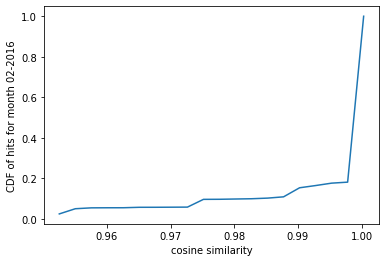

In [141]:
score_df = pd.read_json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2016-02.scores.json', orient='records')
scores = score_df['cosine_similarity'].to_list()
counts, bin_edges = np.histogram (scores, bins=20, normed=False)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('cosine similarity')
plt.ylabel('CDF of hits for month 02-2016')

In [109]:
print(bin_edges)
print(counts)

[0.95000696 0.95252219 0.95503741 0.95755264 0.96006787 0.96258309
 0.96509832 0.96761355 0.97012878 0.972644   0.97515923 0.97767446
 0.98018968 0.98270491 0.98522014 0.98773537 0.99025059 0.99276582
 0.99528105 0.99779627 1.0003115 ]
[  664   699   119    11     3    60     3    11    11  1045    10    37
    36    84   173  1221   300   324   135 22360]


# Setting up pyspark to access reddit data in json format randomly

In [143]:
# ## Set up of PysSpark dataframe for Reddit Data
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import col, asc

# You can configure the SparkContext

conf = SparkConf()
conf.set('spark.local.dir', '/INET/state-trolls/work/state-trolls/poc/')
conf.set('spark.sql.shuffle.partitions', '2100')
SparkContext.setSystemProperty('spark.executor.memory', '10g')
SparkContext.setSystemProperty('spark.driver.memory', '10g')
sc = SparkContext(appName='mm_exp', conf=conf)
sqlContext = pyspark.SQLContext(sc)

reddit_data = sqlContext.read.json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/RC_2016-02.bz2.decompressed')

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=mm_exp, master=local[*]) created by __init__ at <ipython-input-110-9d5b38be6761>:14 

# Random hits for annotation

In [281]:
import json
with open('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2016-01.scores.json', 'r') as read_file:
    jdata = json.load(read_file)
another_df = pd.DataFrame(jdata)

In [282]:
len(another_df)

21730

In [272]:
# Get 2000 random samples from matches of one month's data
sample_df = another_df.sample(n = 17000)

In [284]:
reddit_data = sqlContext.read.json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/RC_2016-07.bz2.decompressed')

In [285]:
i = 0
count = [0,0,0,0,0]
selected_hits_tweets = []
for index, row in another_df.iterrows():
    i = i + 1
    print(i)
    tweet_id = row['tweet_id']
    post_id = row['post_id']
    cos_sim = row['cosine_similarity']
    cos_sim = float(cos_sim)
    tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
    tweet_text = tweet.iloc[0]['processed_tweets']
    if (len(tweet_text) > 50):
        if (cos_sim >= 0.95):
            if (cos_sim >= 0.99) & (count[4] != 101):
                count[4] = count[4] + 1
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
                post_time = datetime.utcfromtimestamp(int(post['created_utc']))
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
                print(d)
                print(count)
                selected_hits.append(d)           
            elif ((cos_sim >= 0.98) & (cos_sim < 0.99)) & (count[3] != 100):
                count[3] = count[3] + 1
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
                post_time = datetime.utcfromtimestamp(int(post['created_utc']))
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
                print(d)
                print(count)
                selected_hits.append(d)    
            elif ((cos_sim >= 0.97) & (cos_sim < 0.98)) & (count[2] != 100):
                count[2] = count[2] + 1
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
                post_time = datetime.utcfromtimestamp(int(post['created_utc']))
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
                print(d)
                print(count)
                selected_hits.append(d)    
            elif ((cos_sim >= 0.96) & (cos_sim < 0.97)) & (count[1] != 100):
                count[1] = count[1] + 1
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
                post_time = datetime.utcfromtimestamp(int(post['created_utc']))
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
                print(d)
                print(count)
                selected_hits.append(d)    
            elif (count[0] != 100):
                count[0] = count[0] + 1
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
                post_time = datetime.utcfromtimestamp(int(post['created_utc']))
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
                print(d)
                print(count)
                selected_hits.append(d)    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142


3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825


5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444


6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148


8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628


10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
{'tweet': ' 🇺🇸OHIO 🏙Cleveland🏈Browns⚾Indians   🕴HesWithUs💞ImWithYou💪America⚖MAGA Dont❓Believe❗️me😏Just📺Watch🕴 ', 'post': '📅📆📅📆📅📆📅📆📅', 'sim': 0.96386683}
[100, 95, 100, 100, 101]
10126
{'tweet': ' ┳╱╭╮┓┓┳┓TMPLUZ💯 ┃╱┃┃┃┃┣ ┻┛╰╯╰╯┻┛FRIENDS 🌸🌸🌸🌸🌸      ', 'post': '📅📆📅📆📅📆📅📆📅', 'sim': 0.96386683}
[100, 96, 100, 100, 101]
10127
1

11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
1144

12687
12688
12689
12690
12691
12692
12693
12694
12695
12696
12697
12698
12699
12700
12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
12722
12723
12724
12725
12726
12727
12728
12729
12730
12731
12732
12733
12734
12735
12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
1285

14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
1423

15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
1569

16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
1708

18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
1853

19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
1997

21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
2134

In [297]:
selected_hits_df = pd.DataFrame(selected_hits)
selected_hits_df.to_csv('./selected_hits.csv', sep = ',')

# Plotting the CDF of time difference between tweets and posts

In [298]:
import json
with open('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2016-07.scores.json', 'r') as read_file:
    jdata = json.load(read_file)
another_df = pd.DataFrame(jdata)

In [299]:
reddit_data = sqlContext.read.json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/RC_2016-07.bz2.decompressed')

In [307]:
print(len(another_df))
i = 0
time_diff = []
for index, row in another_df.iterrows():
    print(i)
    i = i + 1
    tweet_id = row['tweet_id']
#     print('tweet_id: ', tweet_id)
    post_id = row['post_id']
    cos_sim = row['cosine_similarity']
    cos_sim = float(cos_sim)
    tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
    tweet_text = tweet.iloc[0]['processed_tweets']
    post = reddit_data.where((col("id") == post_id)).collect()[0]
    post_text = post['body']
    tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
    post_time = datetime.utcfromtimestamp(int(post['created_utc']))
    diff = abs(pd.Timedelta(tweet_time - post_time).days)#.seconds / 3600.0
    print(tweet_time, post_time, diff)
#     d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
    time_diff.append(diff)           

21730
0
2016-02-01 19:47:00 2016-07-31 23:57:09 182
1
2016-12-19 05:14:00 2016-07-31 23:57:09 140
2
2017-03-30 17:50:00 2016-07-31 23:57:09 241
3
2016-10-06 23:41:00 2016-07-31 23:57:09 66
4
2016-06-23 13:48:00 2016-07-31 23:57:09 39
5
2016-12-10 12:59:00 2016-07-31 23:57:09 131
6
2016-12-10 13:03:00 2016-07-31 23:57:09 131
7
2016-10-06 23:25:00 2016-07-31 23:57:09 66
8
2016-09-26 18:06:00 2016-07-31 23:57:09 56
9
2016-08-17 07:53:00 2016-07-31 23:57:09 16
10
2016-08-21 12:27:00 2016-07-31 23:57:09 20
11
2017-04-27 03:08:00 2016-07-31 23:57:09 269
12
2017-01-16 16:21:00 2016-07-31 23:57:09 168
13
2017-03-19 23:31:00 2016-07-31 23:57:09 230
14
2016-10-06 23:52:00 2016-07-31 23:57:09 66
15
2016-11-22 09:00:00 2016-07-31 23:57:10 113
16
2016-09-18 06:53:00 2016-07-31 23:57:10 48
17
2017-01-16 00:10:00 2016-07-31 23:57:10 168
18
2016-06-10 01:07:00 2016-07-31 23:57:10 52
19
2017-06-15 06:55:00 2016-07-31 23:57:10 318
20
2016-08-05 07:06:00 2016-07-31 23:57:10 4
21
2017-01-20 22:38:00 2016-

2017-03-27 02:01:00 2016-07-31 23:57:18 238
176
2016-03-07 16:58:00 2016-07-31 23:57:18 147
177
2017-02-17 02:36:00 2016-07-31 23:57:18 200
178
2016-10-13 15:43:00 2016-07-31 23:57:18 73
179
2016-11-13 04:02:00 2016-07-31 23:57:18 104
180
2016-01-04 20:22:00 2016-07-31 23:57:18 210
181
2016-11-02 22:19:00 2016-07-31 23:57:18 93
182
2016-09-23 16:05:00 2016-07-31 23:57:18 53
183
2016-11-15 12:09:00 2016-07-31 23:57:18 106
184
2016-10-13 19:48:00 2016-07-31 23:57:18 73
185
2016-12-13 21:16:00 2016-07-31 23:57:18 134
186
2016-10-22 19:39:00 2016-07-31 23:57:18 82
187
2017-01-17 15:51:00 2016-07-31 23:57:18 169
188
2016-10-22 19:39:00 2016-07-31 23:57:18 82
189
2016-10-30 23:56:00 2016-07-31 23:57:18 90
190
2016-06-30 15:51:00 2016-07-31 23:57:18 32
191
2016-10-08 12:26:00 2016-07-31 23:57:18 68
192
2016-10-23 05:03:00 2016-07-31 23:57:18 83
193
2017-02-11 08:20:00 2016-07-31 23:57:18 194
194
2017-02-17 02:52:00 2016-07-31 23:57:18 200
195
2016-09-18 18:11:00 2016-07-31 23:57:18 48
196
201

2016-11-29 20:14:00 2016-07-31 23:57:37 120
348
2017-01-23 14:48:00 2016-07-31 23:57:37 175
349
2016-06-21 14:03:00 2016-07-31 23:57:37 41
350
2017-03-30 23:15:00 2016-07-31 23:57:37 241
351
2017-01-23 14:51:00 2016-07-31 23:57:37 175
352
2016-04-20 09:42:00 2016-07-31 23:57:37 103
353
2016-02-27 00:26:00 2016-07-31 23:57:37 156
354
2016-12-25 02:41:00 2016-07-31 23:57:37 146
355
2016-07-02 00:39:00 2016-07-31 23:57:37 30
356
2017-01-23 15:16:00 2016-07-31 23:57:37 175
357
2016-07-20 14:35:00 2016-07-31 23:57:37 12
358
2017-02-15 07:46:00 2016-07-31 23:57:37 198
359
2016-06-21 00:18:00 2016-07-31 23:57:37 41
360
2017-01-23 14:27:00 2016-07-31 23:57:37 175
361
2016-09-23 16:05:00 2016-07-31 23:57:37 53
362
2016-04-25 13:21:00 2016-07-31 23:57:37 98
363
2017-01-23 14:53:00 2016-07-31 23:57:37 175
364
2016-07-15 02:56:00 2016-07-31 23:57:37 17
365
2016-02-26 21:22:00 2016-07-31 23:57:37 157
366
2017-03-27 21:38:00 2016-07-31 23:57:37 238
367
2016-01-22 00:17:00 2016-07-31 23:57:37 192
368

2016-01-22 17:51:00 2016-07-31 23:57:41 192
521
2016-10-02 14:28:00 2016-07-31 23:57:41 62
522
2016-03-05 16:15:00 2016-07-31 23:57:41 149
523
2016-02-14 12:53:00 2016-07-31 23:57:41 169
524
2017-01-17 03:17:00 2016-07-31 23:57:41 169
525
2016-04-16 07:03:00 2016-07-31 23:57:41 107
526
2017-02-01 16:55:00 2016-07-31 23:57:41 184
527
2017-02-03 08:17:00 2016-07-31 23:57:41 186
528
2016-06-22 11:07:00 2016-07-31 23:57:41 40
529
2016-05-07 17:40:00 2016-07-31 23:57:41 86
530
2016-05-04 13:05:00 2016-07-31 23:57:41 89
531
2017-06-07 23:17:00 2016-07-31 23:57:41 310
532
2016-10-02 12:41:00 2016-07-31 23:57:41 62
533
2017-01-06 15:45:00 2016-07-31 23:57:41 158
534
2016-04-03 13:40:00 2016-07-31 23:57:41 120
535
2017-01-07 01:10:00 2016-07-31 23:57:41 159
536
2016-06-11 15:35:00 2016-07-31 23:57:41 51
537
2016-06-08 14:28:00 2016-07-31 23:57:41 54
538
2016-06-09 16:50:00 2016-07-31 23:57:41 53
539
2016-12-24 03:04:00 2016-07-31 23:57:41 145
540
2016-01-04 14:54:00 2016-07-31 23:57:41 210
541


2017-01-29 21:41:00 2016-07-31 23:57:48 181
694
2016-11-30 14:48:00 2016-07-31 23:57:48 121
695
2016-10-31 04:41:00 2016-07-31 23:57:48 91
696
2017-03-01 05:27:00 2016-07-31 23:57:48 212
697
2016-10-31 04:34:00 2016-07-31 23:57:48 91
698
2016-08-10 00:51:00 2016-07-31 23:57:48 9
699
2017-05-29 17:27:00 2016-07-31 23:57:48 301
700
2016-01-22 23:24:00 2016-07-31 23:57:48 192
701
2016-01-11 03:55:00 2016-07-31 23:57:48 203
702
2017-05-09 17:22:00 2016-07-31 23:57:48 281
703
2016-09-12 18:18:00 2016-07-31 23:57:48 42
704
2016-09-06 13:31:00 2016-07-31 23:57:48 36
705
2017-02-15 13:34:00 2016-07-31 23:57:48 198
706
2017-04-08 04:22:00 2016-07-31 23:57:48 250
707
2016-06-22 15:13:00 2016-07-31 23:57:48 40
708
2016-09-10 11:19:00 2016-07-31 23:57:48 40
709
2016-09-26 14:43:00 2016-07-31 23:57:48 56
710
2016-03-13 14:17:00 2016-07-31 23:57:48 141
711
2016-02-27 08:27:00 2016-07-31 23:57:48 156
712
2016-11-22 18:47:00 2016-07-31 23:57:48 113
713
2017-03-19 20:36:00 2016-07-31 23:57:48 230
714
2

2017-01-22 01:16:00 2016-07-31 23:57:48 174
867
2016-06-08 14:02:00 2016-07-31 23:57:48 54
868
2017-01-17 03:22:00 2016-07-31 23:57:48 169
869
2016-10-02 15:18:00 2016-07-31 23:57:48 62
870
2016-11-18 16:39:00 2016-07-31 23:57:48 109
871
2016-05-07 19:15:00 2016-07-31 23:57:48 86
872
2017-03-21 17:03:00 2016-07-31 23:57:48 232
873
2016-11-26 03:35:00 2016-07-31 23:57:48 117
874
2016-12-15 17:42:00 2016-07-31 23:57:48 136
875
2017-04-13 03:59:00 2016-07-31 23:57:48 255
876
2016-01-04 14:43:00 2016-07-31 23:57:48 210
877
2016-06-09 16:26:00 2016-07-31 23:57:48 53
878
2016-12-13 20:24:00 2016-07-31 23:57:48 134
879
2016-10-02 14:23:00 2016-07-31 23:57:48 62
880
2016-10-07 03:55:00 2016-07-31 23:57:48 67
881
2016-06-08 14:15:00 2016-07-31 23:57:48 54
882
2016-05-07 17:56:00 2016-07-31 23:57:48 86
883
2016-10-02 13:07:00 2016-07-31 23:57:48 62
884
2016-05-06 16:47:00 2016-07-31 23:57:48 87
885
2016-01-23 07:50:00 2016-07-31 23:57:48 191
886
2016-06-09 16:56:00 2016-07-31 23:57:48 53
887
201

2016-12-01 03:10:00 2016-07-31 23:57:52 122
1039
2017-02-27 18:47:00 2016-07-31 23:57:52 210
1040
2017-04-16 21:52:00 2016-07-31 23:57:52 258
1041
2016-03-25 16:08:00 2016-07-31 23:57:52 129
1042
2016-11-18 13:09:00 2016-07-31 23:57:52 109
1043
2016-09-17 16:47:00 2016-07-31 23:57:52 47
1044
2016-12-25 00:27:00 2016-07-31 23:57:52 146
1045
2017-01-03 16:56:00 2016-07-31 23:57:52 155
1046
2016-12-04 20:20:00 2016-07-31 23:57:52 125
1047
2016-12-14 21:52:00 2016-07-31 23:57:52 135
1048
2016-10-08 01:37:00 2016-07-31 23:57:52 68
1049
2016-06-28 15:54:00 2016-07-31 23:57:52 34
1050
2016-09-16 11:47:00 2016-07-31 23:57:52 46
1051
2016-08-28 14:20:00 2016-07-31 23:57:52 27
1052
2017-01-09 05:08:00 2016-07-31 23:57:52 161
1053
2016-03-19 02:32:00 2016-07-31 23:57:52 135
1054
2016-10-20 12:26:00 2016-07-31 23:57:52 80
1055
2016-06-29 17:34:00 2016-07-31 23:57:52 33
1056
2016-06-29 17:52:00 2016-07-31 23:57:52 33
1057
2016-03-31 19:28:00 2016-07-31 23:57:52 123
1058
2016-06-21 14:00:00 2016-07-

2016-10-08 23:27:00 2016-07-31 23:57:52 68
1209
2016-10-29 19:33:00 2016-07-31 23:57:52 89
1210
2016-06-28 16:45:00 2016-07-31 23:57:52 34
1211
2017-04-17 04:15:00 2016-07-31 23:57:52 259
1212
2016-08-31 06:32:00 2016-07-31 23:57:52 30
1213
2016-05-12 16:05:00 2016-07-31 23:57:52 81
1214
2016-07-01 11:24:00 2016-07-31 23:57:52 31
1215
2017-02-09 01:29:00 2016-07-31 23:57:52 192
1216
2017-02-23 00:39:00 2016-07-31 23:57:52 206
1217
2017-01-14 18:03:00 2016-07-31 23:57:52 166
1218
2016-05-15 18:12:00 2016-07-31 23:57:52 78
1219
2016-10-11 02:30:00 2016-07-31 23:57:52 71
1220
2016-08-24 13:43:00 2016-07-31 23:57:52 23
1221
2017-01-11 00:48:00 2016-07-31 23:57:52 163
1222
2016-02-06 00:24:00 2016-07-31 23:57:52 177
1223
2016-02-24 13:22:00 2016-07-31 23:57:52 159
1224
2017-02-11 06:09:00 2016-07-31 23:57:52 194
1225
2016-10-25 15:40:00 2016-07-31 23:57:52 85
1226
2016-11-03 20:05:00 2016-07-31 23:57:52 94
1227
2016-06-15 01:19:00 2016-07-31 23:57:52 47
1228
2016-08-10 19:13:00 2016-07-31 2

2017-02-27 03:04:00 2016-07-31 23:57:58 210
1378
2017-04-15 12:16:00 2016-07-31 23:57:58 257
1379
2017-06-19 02:00:00 2016-07-31 23:57:58 322
1380
2016-06-30 16:02:00 2016-07-31 23:57:58 32
1381
2017-06-30 12:02:00 2016-07-31 23:58:00 333
1382
2017-06-26 22:55:00 2016-07-31 23:58:00 329
1383
2017-04-29 01:29:00 2016-07-31 23:58:00 271
1384
2017-06-03 00:37:00 2016-07-31 23:58:00 306
1385
2016-07-11 10:41:00 2016-07-31 23:58:00 21
1386
2017-04-21 02:38:00 2016-07-31 23:58:00 263
1387
2017-06-27 05:34:00 2016-07-31 23:58:00 330
1388
2016-08-30 19:59:00 2016-07-31 23:58:00 29
1389
2016-07-16 21:39:00 2016-07-31 23:58:00 16
1390
2016-11-29 02:50:00 2016-07-31 23:58:00 120
1391
2017-04-16 20:56:00 2016-07-31 23:58:00 258
1392
2016-12-27 05:20:00 2016-07-31 23:58:00 148
1393
2017-06-23 02:44:00 2016-07-31 23:58:00 326
1394
2017-05-08 18:37:00 2016-07-31 23:58:00 280
1395
2017-04-16 20:56:00 2016-07-31 23:58:00 258
1396
2017-04-04 22:32:00 2016-07-31 23:58:00 246
1397
2017-04-18 16:12:00 2016

2016-10-12 03:28:00 2016-07-31 23:58:05 72
1547
2016-03-08 03:20:00 2016-07-31 23:58:06 146
1548
2016-11-29 02:45:00 2016-07-31 23:58:06 120
1549
2016-05-29 03:22:00 2016-07-31 23:58:06 64
1550
2016-08-08 09:35:00 2016-07-31 23:58:06 7
1551
2016-08-08 09:29:00 2016-07-31 23:58:06 7
1552
2016-08-08 10:44:00 2016-07-31 23:58:06 7
1553
2016-08-08 09:15:00 2016-07-31 23:58:06 7
1554
2016-08-08 09:20:00 2016-07-31 23:58:06 7
1555
2016-01-23 07:44:00 2016-07-31 23:58:06 191
1556
2016-08-08 09:03:00 2016-07-31 23:58:06 7
1557
2016-08-08 11:25:00 2016-07-31 23:58:06 7
1558
2016-08-08 09:30:00 2016-07-31 23:58:06 7
1559
2016-08-08 10:32:00 2016-07-31 23:58:06 7
1560
2016-08-08 10:05:00 2016-07-31 23:58:06 7
1561
2016-08-08 09:31:00 2016-07-31 23:58:06 7
1562
2016-08-08 11:37:00 2016-07-31 23:58:06 7
1563
2016-08-08 09:52:00 2016-07-31 23:58:06 7
1564
2016-08-08 09:11:00 2016-07-31 23:58:06 7
1565
2016-08-08 10:27:00 2016-07-31 23:58:06 7
1566
2016-08-08 09:41:00 2016-07-31 23:58:06 7
1567
2016-

KeyboardInterrupt: 

/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'CDF of hits for month 02-2016')

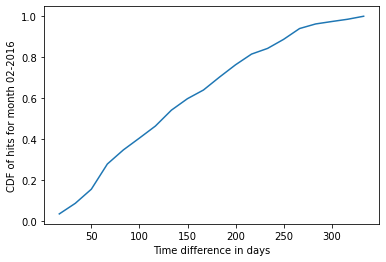

In [308]:
counts, bin_edges = np.histogram (time_diff, bins=20, normed=False)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Time difference in days')
plt.ylabel('CDF of random hits for month 02-2016')

In [309]:
print(bin_edges)
print(counts)

[  0.    16.65  33.3   49.95  66.6   83.25  99.9  116.55 133.2  149.85
 166.5  183.15 199.8  216.45 233.1  249.75 266.4  283.05 299.7  316.35
 333.  ]
[ 61  88 117 209 117  98 100 132  95  72 107 102  89  47  75  90  38  20
  19  25]


# Analysing a random tweet for time of post

In [326]:
import json
hits = []
for i in range(1,8):
    with open('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2016-0' + str(i) +'.scores.json', 'r') as read_file:
        jdata = json.load(read_file)
        for entry in jdata:
            hits.append(entry)
hits_df = pd.DataFrame(hits)

In [334]:
for index,row in hits_df.iterrows():
    tweet_id = row['tweet_id']
    print('tweet_id: ', tweet_id)
#     post_id = row['post_id']
#     cos_sim = row['cosine_similarity']
#     cos_sim = float(cos_sim)
    tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
    tweet_text = tweet.iloc[0]['processed_tweets']
    print('tweet_text: ', tweet_text)

tweet_id:  847351934381981697
tweet_text:   Wow wow 
tweet_id:  857882340357414912
tweet_text:   Source 
  
tweet_id:  747453575991726080
tweet_text:   Source  
tweet_id:  739426262947631104
tweet_text:    Source 
tweet_id:  798554726086283265
tweet_text:   source
tweet_id:  818341358847086592
tweet_text:    source 
tweet_id:  793874529017880577
tweet_text:   source
tweet_id:  697958108941791232
tweet_text:  Source  
tweet_id:  695788388281143297
tweet_text:   source
tweet_id:  811654307950907392
tweet_text:   source  
tweet_id:  810879975402471424
tweet_text:   I love you 
tweet_id:  821709362716610561
tweet_text:  I love you
tweet_id:  784260592429215744
tweet_text:   i love you 
tweet_id:  810853904330133504
tweet_text:   I love you 
tweet_id:  810886517379964928
tweet_text:   I love you 
tweet_id:  810874880883392513
tweet_text:   I love you 
tweet_id:  810867085547073536
tweet_text:   I love you 
tweet_id:  810864703937318912
tweet_text:   I love you 
tweet_id:  787771411276374020

tweet_text:   Thank you 
tweet_id:  776992155034349568
tweet_text:   Thank you 
tweet_id:  766677055811514368
tweet_text:   thank you 
tweet_id:  782562380446302208
tweet_text:   thank you
tweet_id:  733201470284128256
tweet_text:   Thank you 
tweet_id:  809610068362674177
tweet_text:   Thank YOU 
tweet_id:  772815598325608448
tweet_text:    thank you
tweet_id:  788308207005564928
tweet_text:       Thank you
tweet_id:  782584412949057536
tweet_text:   thank you
tweet_id:  840294795792797696
tweet_text:       Thank You
tweet_id:  824829364445577220
tweet_text:    Thank you 
tweet_id:  777033744146456576
tweet_text:   Thank you   
tweet_id:  785897626247933952
tweet_text:    Thank you
tweet_id:  796226491403173888
tweet_text:   THANK YOU 
tweet_id:  766674808461484032
tweet_text:   thank you 
tweet_id:  732223266308423680
tweet_text:   Thank you 
tweet_id:  791292611747250176
tweet_text:   Thank you 
tweet_id:  784117863921639425
tweet_text:   Thank you 
tweet_id:  772817899199275012
twe

tweet_text:   Thank you 
tweet_id:  784118719198789632
tweet_text:   Thank you 
tweet_id:  697324600611336192
tweet_text:   Thank you 
tweet_id:  856845219467284480
tweet_text:   Thank you  
tweet_id:  788726338538602496
tweet_text:   Thank you  
tweet_id:  816970163853606913
tweet_text:   Thank you  
tweet_id:  688192648922808320
tweet_text:    
Thank You 
tweet_id:  837801563104014336
tweet_text:   Thank You 
tweet_id:  863410492995387392
tweet_text:   THANK YOU    
tweet_id:  802296699091910656
tweet_text:     thank you  
tweet_id:  817646370077245442
tweet_text:   Thank you 
tweet_id:  784117996604174339
tweet_text:   Thank you 
tweet_id:  782620261380161536
tweet_text:  thank you 
tweet_id:  782562513145724928
tweet_text:  thank you 
tweet_id:  727849793540661248
tweet_text:   thank you
tweet_id:  782587733806051328
tweet_text:  THANK YOU 
tweet_id:  724504246448709632
tweet_text:   thank you
tweet_id:  859172500198109185
tweet_text:    Thank you
tweet_id:  777229296192458752
twee

tweet_text:   Thank you 
tweet_id:  766677055811514368
tweet_text:   thank you 
tweet_id:  782562380446302208
tweet_text:   thank you
tweet_id:  733201470284128256
tweet_text:   Thank you 
tweet_id:  809610068362674177
tweet_text:   Thank YOU 
tweet_id:  772815598325608448
tweet_text:    thank you
tweet_id:  788308207005564928
tweet_text:       Thank you
tweet_id:  782584412949057536
tweet_text:   thank you
tweet_id:  840294795792797696
tweet_text:       Thank You
tweet_id:  824829364445577220
tweet_text:    Thank you 
tweet_id:  777033744146456576
tweet_text:   Thank you   
tweet_id:  785897626247933952
tweet_text:    Thank you
tweet_id:  796226491403173888
tweet_text:   THANK YOU 
tweet_id:  766674808461484032
tweet_text:   thank you 
tweet_id:  732223266308423680
tweet_text:   Thank you 
tweet_id:  791292611747250176
tweet_text:   Thank you 
tweet_id:  784117863921639425
tweet_text:   Thank you 
tweet_id:  772817899199275012
tweet_text:    thank you
tweet_id:  836017638597881857
twe

tweet_text:   Thank you 
tweet_id:  856845219467284480
tweet_text:   Thank you  
tweet_id:  788726338538602496
tweet_text:   Thank you  
tweet_id:  816970163853606913
tweet_text:   Thank you  
tweet_id:  688192648922808320
tweet_text:    
Thank You 
tweet_id:  837801563104014336
tweet_text:   Thank You 
tweet_id:  863410492995387392
tweet_text:   THANK YOU    
tweet_id:  802296699091910656
tweet_text:     thank you  
tweet_id:  817646370077245442
tweet_text:   Thank you 
tweet_id:  784117996604174339
tweet_text:   Thank you 
tweet_id:  782620261380161536
tweet_text:  thank you 
tweet_id:  782562513145724928
tweet_text:  thank you 
tweet_id:  727849793540661248
tweet_text:   thank you
tweet_id:  782587733806051328
tweet_text:  THANK YOU 
tweet_id:  724504246448709632
tweet_text:   thank you
tweet_id:  859172500198109185
tweet_text:    Thank you
tweet_id:  777229296192458752
tweet_text:   Thank you  
tweet_id:  697343589295091713
tweet_text:   Thank you 
tweet_id:  808503070422429696
twe

tweet_text:   Thanks
tweet_id:  684709816627892225
tweet_text:   thanks 
tweet_id:  786173689288990720
tweet_text:    Thanks   
tweet_id:  802814011578269697
tweet_text:   Thanks  
tweet_id:  804687289179746304
tweet_text:   Thanks 
tweet_id:  782573587651764224
tweet_text:  Thanks 
tweet_id:  804171706143305728
tweet_text:   Thanks        
tweet_id:  690083259292721153
tweet_text:    Thanks
tweet_id:  782570957223362561
tweet_text:  Thanks 
tweet_id:  782579394917363712
tweet_text:  Thanks 
tweet_id:  804697377525202944
tweet_text:   Thanks 
tweet_id:  776902006380367874
tweet_text:   Thanks 
tweet_id:  782578505733332993
tweet_text:  Thanks 
tweet_id:  841497234172600322
tweet_text:    thanks
tweet_id:  729004648791707649
tweet_text:   Thanks 
tweet_id:  857485731677294598
tweet_text:   Thanks 
tweet_id:  782577111739621378
tweet_text:  Thanks 
tweet_id:  736599139153154049
tweet_text:   Thanks  
tweet_id:  782553678796451840
tweet_text:   thanks
tweet_id:  782559857786445824
tweet_t

tweet_text:   Agreed agreed 
tweet_id:  880758482244321280
tweet_text:    Thanks
tweet_id:  879473241227575296
tweet_text:   Thanks
tweet_id:  858131162396475392
tweet_text:  Thanks
tweet_id:  870801459780112384
tweet_text:   Thanks
tweet_id:  752452721819521024
tweet_text:   thanks
tweet_id:  855249362343010304
tweet_text:   Thanks
tweet_id:  879573706871160832
tweet_text:   Thanks
tweet_id:  770712620613632000
tweet_text:   
Thanks
tweet_id:  754430373795278848
tweet_text:   thanks
tweet_id:  803430979553505285
tweet_text:   Thanks  
tweet_id:  853713653979201536
tweet_text:   Thanks 
tweet_id:  813615487439355904
tweet_text:   Thanks 
tweet_id:  878081316012474369
tweet_text:            Thanks
tweet_id:  861651327914459136
tweet_text:   Thanks
tweet_id:  853713649990385664
tweet_text:   Thanks 
tweet_id:  849389266744614913
tweet_text:   Thanks      
tweet_id:  854367005415055360
tweet_text:   Thanks
tweet_id:  859618647186321410
tweet_text:   Thanks
tweet_id:  855628437083508736
tw

tweet_text:      So true
tweet_id:  833960924822151169
tweet_text:       So True
tweet_id:  777835165435297792
tweet_text:   So true 
tweet_id:  819610849602109440
tweet_text:   So true  
tweet_id:  728673854940315649
tweet_text:   So true 
tweet_id:  830189734290915328
tweet_text:   So True 
tweet_id:  724762426655170560
tweet_text:  So true 
tweet_id:  733339004788170754
tweet_text:     so true
tweet_id:  694968293824847873
tweet_text:   So true 
tweet_id:  724921330970271744
tweet_text:  So true 
tweet_id:  819504814644142080
tweet_text:    so true  
tweet_id:  840234957826084864
tweet_text:   So true 
tweet_id:  835509552728637440
tweet_text:   So true 
tweet_id:  730780347806322689
tweet_text:  So true 
tweet_id:  791364338367868928
tweet_text:  So true 
tweet_id:  721693838079725569
tweet_text:  so true 
tweet_id:  796816882368212992
tweet_text:  So true 
tweet_id:  694963491048964098
tweet_text:   So true 
tweet_id:  695077535265062913
tweet_text:   So true 
tweet_id:  702855714

tweet_text:  Thank you 
tweet_id:  760858465665294336
tweet_text:   thank you
tweet_id:  785884937907941376
tweet_text:   Thank you 
tweet_id:  831662243246964736
tweet_text:   Thank you 
tweet_id:  857690600526807045
tweet_text:   Thank you 
tweet_id:  772799949004271616
tweet_text:    thank you
tweet_id:  822572662404816897
tweet_text:   THANK YOU
tweet_id:  860118190579474433
tweet_text:   thank you 
tweet_id:  697341153801170944
tweet_text:   Thank you 
tweet_id:  733275208728076289
tweet_text:   Thank you
tweet_id:  836940571126063105
tweet_text:   THANK YOU
tweet_id:  791485346592677888
tweet_text:     thank you
tweet_id:  794296696285097984
tweet_text:   Thank you 
tweet_id:  747717684767363072
tweet_text:   thank you
tweet_id:  807310393508962304
tweet_text:     
Thank you
tweet_id:  821080428077465602
tweet_text:          Thank you 
tweet_id:  744074731117121536
tweet_text:   Thank you   
tweet_id:  837377724482125824
tweet_text:   THANK YOU
tweet_id:  871081409154129920
tweet

tweet_id:  688192648922808320
tweet_text:    
Thank You 
tweet_id:  837801563104014336
tweet_text:   Thank You 
tweet_id:  863410492995387392
tweet_text:   THANK YOU    
tweet_id:  802296699091910656
tweet_text:     thank you  
tweet_id:  817646370077245442
tweet_text:   Thank you 
tweet_id:  784117996604174339
tweet_text:   Thank you 
tweet_id:  782620261380161536
tweet_text:  thank you 
tweet_id:  782562513145724928
tweet_text:  thank you 
tweet_id:  727849793540661248
tweet_text:   thank you
tweet_id:  782587733806051328
tweet_text:  THANK YOU 
tweet_id:  724504246448709632
tweet_text:   thank you
tweet_id:  859172500198109185
tweet_text:    Thank you
tweet_id:  777229296192458752
tweet_text:   Thank you  
tweet_id:  697343589295091713
tweet_text:   Thank you 
tweet_id:  808503070422429696
tweet_text:   Thank you
tweet_id:  735155276886740992
tweet_text:    Thank you
tweet_id:  804820030177366016
tweet_text:   Thank you 
tweet_id:  819766585602768896
tweet_text:   Thank you 
tweet_i

tweet_text:   Nope 
tweet_id:  781837665507348481
tweet_text:   nope
tweet_id:  792202087195029504
tweet_text:   Nope 
tweet_id:  701892467147325446
tweet_text:   nope
tweet_id:  716302774397452288
tweet_text:   nope 
tweet_id:  788760835493621760
tweet_text:   Nope 
tweet_id:  797365430365126657
tweet_text:   Nope 
tweet_id:  764446010819026944
tweet_text:   nope 
tweet_id:  788760863058563073
tweet_text:   Nope 
tweet_id:  785763988260827136
tweet_text:   NOPE 
tweet_id:  697522977043251204
tweet_text:   nope
tweet_id:  777265401306685440
tweet_text:   Nope 
tweet_id:  800441473019891712
tweet_text:   Nope 
tweet_id:  708324273543389184
tweet_text:   nope
tweet_id:  796569601769226240
tweet_text:   nope 
tweet_id:  780533413912711168
tweet_text:   nope
tweet_id:  800335237242847233
tweet_text:   Nope  
tweet_id:  836512822003564544
tweet_text:   nope 
tweet_id:  746361173491261441
tweet_text:    Nope
tweet_id:  831536358720229376
tweet_text:   nope 
tweet_id:  786273133783191553
twee

tweet_text:   Lily🙌🙌 
tweet_id:  792112254657277952
tweet_text:   🙋Hello 
tweet_id:  788825549753896960
tweet_text:           👻❤️GHOSTIES❤️👻
tweet_id:  827828610581008385
tweet_text:   IranBuildsNuclearMissilesButCantDoBabyBrainSurgeryGoFukAGoatLyinBabyPlayers👳 
tweet_id:  796067232048709632
tweet_text:   LOOK⤵        
tweet_id:  833232626341310464
tweet_text:   This👇👇👇👇👇 
tweet_id:  832990782265126912
tweet_text:   This👇 
tweet_id:  717595847043600384
tweet_text:  message☝🏽️ 
tweet_id:  844169365809373184
tweet_text:   🔝            
tweet_id:  709025551151984640
tweet_text:   goals😍 
tweet_id:  812051156516143104
tweet_text:    queens✨✨✨ 
tweet_id:  872534395693019138
tweet_text:  CNN👏IS👏CANCER👏 
tweet_id:  819707405344894976
tweet_text:   DRAG👏🏿HIM👏🏿THROUGH👏🏿THE👏🏿MUD 
tweet_id:  842958133056159747
tweet_text:      Word😉🇺🇸
tweet_id:  782598838037180417
tweet_text:  Thanx😊 
tweet_id:  841440914614677504
tweet_text:   This👇👇👇 
tweet_id:  788808151520927744
tweet_text:   Thanks🙋 
tweet_i

tweet_text:      Funny😂😂😂😂😂😂😂Hillary4Prison2016
tweet_id:  723048223359684608
tweet_text:    😡😡😡sickos
tweet_id:  839377231893803008
tweet_text:   Thanks😘😘😘😘
tweet_id:  810156010887229440
tweet_text:   Right😂😂😂
tweet_id:  867672240581627904
tweet_text:   Thanks💡💡💡
tweet_id:  769051822933831680
tweet_text:    Amen❤️❤️❤️🇺🇸🇺🇸
tweet_id:  720361713531392000
tweet_text:     Right😎👍
tweet_id:  833128820144103426
tweet_text:   Whoah👀 
tweet_id:  823578983434330112
tweet_text:     👎NEVER
tweet_id:  796214894873841666
tweet_text:   BESTDAYEVER🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
tweet_id:  754925146305994753
tweet_text:   sickos😡😡
tweet_id:  767341042895089664
tweet_text:  Morning😽 
tweet_id:  826292618309017602
tweet_text:   Gorgeous💖❤ 
tweet_id:  797668849499967488
tweet_text:   Exactly👍❌💯 
tweet_id:  825492326676041728
tweet_text:   WOWZERSSS🔥 
tweet_id:  788826982846914560
tweet_text:           👻❤️GHOSTIES❤️👻
tweet_id:  814809112198443008
tweet_text:   Calming😌 
tweet_id:  782572847726202882
tweet_text:

tweet_text:   Hello😂😂          
tweet_id:  742818112945291265
tweet_text:   This👏is👏true 
tweet_id:  721249969101889536
tweet_text:   LMFAOOOOO😂😂😂😂😂😂😂 
tweet_id:  835861636753731585
tweet_text:    preach💁🏾
tweet_id:  851017889499033600
tweet_text:   soon🍋🍋🍋
tweet_id:  834858992321044482
tweet_text:   Chance4snow2nightHere👍         
tweet_id:  695494046010187776
tweet_text:   Goals👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾 
tweet_id:  690358697650962433
tweet_text:   damn😕 
tweet_id:  814657375252660224
tweet_text:   Amen👊 
tweet_id:  779782990671020037
tweet_text:   Priceless😂
tweet_id:  876513143412994049
tweet_text:             Done✔️
tweet_id:  796086602430906368
tweet_text:   LOOK⤵        
tweet_id:  709002734054338560
tweet_text:   😂😂facts  
tweet_id:  830369362485903360
tweet_text:   AWESOME👍👍❤️❤️ 
tweet_id:  807380394291200000
tweet_text:          YUCK😎
tweet_id:  786252929812434944
tweet_text:   TROLL😁  
tweet_id:  796620187177025536
tweet_text:   Again😂 
tweet_id:  784229169223831552
tweet_text:   

tweet_text:   Welp  
tweet_id:  711545736698204160
tweet_text:   Welp 
tweet_id:  740935799676473344
tweet_text:   Welp 
tweet_id:  826991227241394176
tweet_text:   Welp 
tweet_id:  710503078030610432
tweet_text:   Welp 
tweet_id:  858509780402307072
tweet_text:   Welp 
tweet_id:  797550493371351040
tweet_text:   Welp 
tweet_id:  707579779667595265
tweet_text:   WELP 
tweet_id:  708844420892901376
tweet_text:   Welp 
tweet_id:  834045954118524928
tweet_text:   Welp 
tweet_id:  846013380506910720
tweet_text:   Welp 
tweet_id:  803283606688907265
tweet_text:    welp
tweet_id:  710491477282054144
tweet_text:   Welp 
tweet_id:  710496894288535553
tweet_text:   Welp 
tweet_id:  766025658833203200
tweet_text:   Welp 
tweet_id:  708797474966622208
tweet_text:   Welp 
tweet_id:  858879156771328000
tweet_text:   WELP 
tweet_id:  807066652206596096
tweet_text:   welp
tweet_id:  793266663688986624
tweet_text:   Welp 
tweet_id:  833185259890081792
tweet_text:   Welp 
tweet_id:  834038474911150080


tweet_text:   Thanks 
tweet_id:  727846615738880000
tweet_text:   thanks
tweet_id:  872593482375766016
tweet_text:   Thanks
tweet_id:  782561253592010752
tweet_text:   thanks
tweet_id:  817396736536809472
tweet_text:    thanks        
tweet_id:  716621503123488768
tweet_text:   thanks
tweet_id:  817538894480756740
tweet_text:   Thanks  
tweet_id:  741655196980412417
tweet_text:   thanks
tweet_id:  740551142652805120
tweet_text:   Thanks 
tweet_id:  740949291959758848
tweet_text:   Thanks 
tweet_id:  812494159894499328
tweet_text:   Thanks 
tweet_id:  684025142905679872
tweet_text:    Thanks
tweet_id:  774613637998804993
tweet_text:  Thanks 
tweet_id:  822471410169872385
tweet_text:   thanks
tweet_id:  684025806759198720
tweet_text:    Thanks
tweet_id:  689460416800403456
tweet_text:        Thanks
tweet_id:  774079964278771712
tweet_text:   Thanks 
tweet_id:  720807650867486720
tweet_text:   Thanks
tweet_id:  740939387962335233
tweet_text:   Thanks 
tweet_id:  782579057196146688
tweet_t

tweet_text:   YES YES YES 
tweet_id:  789280799619096576
tweet_text:   Yes Yes Yes 
tweet_id:  781823505683849216
tweet_text:     Yes Yes Yes
tweet_id:  814269162222747648
tweet_text:   Yes yes yes 
tweet_id:  797934007237431297
tweet_text:  Yes yes yes 
tweet_id:  846894314596712453
tweet_text:   Yes Yes Yes 
tweet_id:  856640513973399552
tweet_text:   Yes Yes Yes   
tweet_id:  801516887221932032
tweet_text:   YES YES YES 
tweet_id:  813159545996394497
tweet_text:    YES YES YES
tweet_id:  845431667225313280
tweet_text:   Yes yes yes 
tweet_id:  768451186026512385
tweet_text:  YES YES YES 
tweet_id:  858734356717649920
tweet_text:   Yes Yes Yes Yes 
tweet_id:  856513471491559424
tweet_text:   yes yes yes yes 
tweet_id:  864839477042315264
tweet_text:   Yes Yes Yes Yes Yes
tweet_id:  748270020623368193
tweet_text:    YES YES YES YES YES
tweet_id:  763231182670606338
tweet_text:   yes yes yes yes yes
tweet_id:  854092267510009856
tweet_text:   YES yes yes yes yes yes YES 
tweet_id:  742

tweet_text:   Thank you 
tweet_id:  849078165146390530
tweet_text:     Thank you
tweet_id:  707427338686832641
tweet_text:   Thank you  
tweet_id:  837044470885433344
tweet_text:   THANK YOU

tweet_id:  824428873869778944
tweet_text:    thank you
tweet_id:  771634147680935936
tweet_text:  Thank you 
tweet_id:  857044130790166530
tweet_text:   Thank you  
tweet_id:  709086343037583360
tweet_text:   Thank you  
tweet_id:  717471767711784961
tweet_text:   Thank you 
tweet_id:  824462723312484353
tweet_text:  Thank you  
  
tweet_id:  827499902754254852
tweet_text:   Thank you 
tweet_id:  743758325536325633
tweet_text:   Thank you
tweet_id:  846103715320881154
tweet_text:   Thank you 
tweet_id:  854498133837000704
tweet_text:   Thank you 
tweet_id:  738044665971146752
tweet_text:    thank you        
tweet_id:  782574783724658688
tweet_text:  Thank you 
tweet_id:  855151865608245250
tweet_text:            THANK YOU
tweet_id:  836994230350315522
tweet_text:   THANK YOU
tweet_id:  7841191726

tweet_text:  THANK YOU 
tweet_id:  724504246448709632
tweet_text:   thank you
tweet_id:  859172500198109185
tweet_text:    Thank you
tweet_id:  777229296192458752
tweet_text:   Thank you  
tweet_id:  697343589295091713
tweet_text:   Thank you 
tweet_id:  808503070422429696
tweet_text:   Thank you
tweet_id:  735155276886740992
tweet_text:    Thank you
tweet_id:  804820030177366016
tweet_text:   Thank you 
tweet_id:  819766585602768896
tweet_text:   Thank you 
tweet_id:  753952104344088577
tweet_text:   Thank you
tweet_id:  785890746050093056
tweet_text:   Thank you 
tweet_id:  727877283009146880
tweet_text:   thank you
tweet_id:  740337470298947584
tweet_text:    Thank you
tweet_id:  772813557184405504
tweet_text:    thank you
tweet_id:  806222924214480896
tweet_text:   THANK YOU 
tweet_id:  782599380734009344
tweet_text:  Thank you 
tweet_id:  733704824403939329
tweet_text:   thank you
tweet_id:  782577528049401856
tweet_text:  Thank you 
tweet_id:  731240805441015808
tweet_text:    Th

tweet_text:   Fuck 
tweet_id:  858117603268734980
tweet_text:   Fuck 
tweet_id:  691539001568825344
tweet_text:   Fuck
tweet_id:  691527591644262405
tweet_text:   Fuck
tweet_id:  726871758863638528
tweet_text:   Fuck 
tweet_id:  858118213485416449
tweet_text:   Fuck 
tweet_id:  858176708972859392
tweet_text:   Fuck 
tweet_id:  758609713798021120
tweet_text:   Fuck
tweet_id:  852236498103435264
tweet_text:   FUCK 
tweet_id:  758601187130236928
tweet_text:   Fuck
tweet_id:  688057452420554756
tweet_text:   fuck 
tweet_id:  858179083456458752
tweet_text:   Fuck 
tweet_id:  858140574418960388
tweet_text:   Fuck 
tweet_id:  758621815556169729
tweet_text:   Fuck
tweet_id:  858121640563142656
tweet_text:   Fuck 
tweet_id:  708926835409682433
tweet_text:   fuck 
tweet_id:  691534633981321216
tweet_text:   Fuck
tweet_id:  793086816438067200
tweet_text:   fuck 
tweet_id:  798790495098912772
tweet_text:   fuck  
tweet_id:  858120787462692864
tweet_text:   Fuck 
tweet_id:  858113248884862982
tweet

tweet_text:  Thank you 
tweet_id:  782597320043003904
tweet_text:  Thank you 
tweet_id:  772801565576957953
tweet_text:    thank you
tweet_id:  836412969592422400
tweet_text:   Thank you 
tweet_id:  755053242988400641
tweet_text:   THANK YOU 
tweet_id:  804694954253500416
tweet_text:   Thank You 
tweet_id:  826607089434890240
tweet_text:   Thank you 
tweet_id:  814180688979251200
tweet_text:   Thank you 
tweet_id:  829890972976820226
tweet_text:   Thank you 
tweet_id:  776992155034349568
tweet_text:   Thank you 
tweet_id:  766677055811514368
tweet_text:   thank you 
tweet_id:  782562380446302208
tweet_text:   thank you
tweet_id:  733201470284128256
tweet_text:   Thank you 
tweet_id:  809610068362674177
tweet_text:   Thank YOU 
tweet_id:  772815598325608448
tweet_text:    thank you
tweet_id:  788308207005564928
tweet_text:       Thank you
tweet_id:  782584412949057536
tweet_text:   thank you
tweet_id:  840294795792797696
tweet_text:       Thank You
tweet_id:  824829364445577220
tweet_te

tweet_id:  742444325175431168
tweet_text:   THANK YOU 
tweet_id:  795750490067927040
tweet_text:    Thank you
tweet_id:  810910996793593856
tweet_text:    thank you
tweet_id:  776537980219654145
tweet_text:   Thank you
tweet_id:  823130656498708480
tweet_text:   Thank you 
tweet_id:  830674620470718464
tweet_text:     thank you
tweet_id:  697332802216398848
tweet_text:   Thank you 
tweet_id:  837983051829358592
tweet_text:   Thank you 
tweet_id:  745217644488318976
tweet_text:   thank you
tweet_id:  695990358904156160
tweet_text:  Thank you 
tweet_id:  695753932254134272
tweet_text:   thank you
tweet_id:  727033377581207552
tweet_text:   thank you
tweet_id:  782559892422918144
tweet_text:  thank you 
tweet_id:  809603260180996097
tweet_text:   Thank YOU 
tweet_id:  788730586571702280
tweet_text:   Thank you  
tweet_id:  745223988129914880
tweet_text:   thank you
tweet_id:  746251728945876992
tweet_text:   Thank you
tweet_id:  784158804384546816
tweet_text:     Thank You
tweet_id:  7123

tweet_text:   Nope Nope Nope  
tweet_id:  771352579322380289
tweet_text:   Nope Nope Nope  
tweet_id:  833955332523229184
tweet_text:   I retweeted everybody to light their souls  But they take the light and start going the opposite way  I must now keep my f…
tweet_id:  757681017842900992
tweet_text:  Thank you  
tweet_id:  725361636006055938
tweet_text:   
Thank you  
tweet_id:  829917135518314496
tweet_text:       Thank You
tweet_id:  874911452594831362
tweet_text:   Thank You
tweet_id:  865064841899155456
tweet_text:   Thank you
tweet_id:  860013192969191424
tweet_text:   Thank you  
tweet_id:  803255054241124352
tweet_text:   Thank you  
tweet_id:  839918228470054912
tweet_text:   Thank you 
tweet_id:  740372495774023681
tweet_text:   Thank you  
tweet_id:  833783378700668928
tweet_text:   Thank You
tweet_id:  870854900762132480
tweet_text:   Thank you
tweet_id:  747133488655175680
tweet_text:   
Thank you 
tweet_id:  871186912890953730
tweet_text:   Thank You
tweet_id:  8216083130

tweet_text:   thank you
tweet_id:  784114187479965696
tweet_text:   Thank you 
tweet_id:  700043211960684545
tweet_text:    thank you
tweet_id:  699636041658064897
tweet_text:   thank you
tweet_id:  812048919295365120
tweet_text:   Thank you 
tweet_id:  746322886256959488
tweet_text:   Thank you
tweet_id:  766675733305405440
tweet_text:   thank you 
tweet_id:  714859062941327361
tweet_text:   Thank you
tweet_id:  807460408680398848
tweet_text:   Thank you 
tweet_id:  728162194739867648
tweet_text:    Thank you 
tweet_id:  782572765555687424
tweet_text:  thank you 
tweet_id:  836969980180762624
tweet_text:   THANK YOU 
tweet_id:  782603369189875712
tweet_text:  Thank you 
tweet_id:  718456919778656260
tweet_text:  Thank you 
tweet_id:  796081491306483712
tweet_text:   Thank you
tweet_id:  776889029623185409
tweet_text:   Thank you  
tweet_id:  734029846821490691
tweet_text:   thank you
tweet_id:  727112415985471489
tweet_text:   thank you
tweet_id:  848299821207347200
tweet_text:   Than

tweet_text:   Thank You 
tweet_id:  728151863334305793
tweet_text:    Thank you 
tweet_id:  698951730675855360
tweet_text:  Thank you 
tweet_id:  790575425043005440
tweet_text:    Thank you
tweet_id:  822064668613181441
tweet_text:     Thank you
tweet_id:  782573637115187202
tweet_text:  Thank you 
tweet_id:  705383813980004352
tweet_text:   Thank you
tweet_id:  689460141612097536
tweet_text:       Thank you
tweet_id:  849422828189491200
tweet_text:   Thank you 
tweet_id:  800422332636528644
tweet_text:   Thank you 
tweet_id:  798923873542619136
tweet_text:   Thank you 
tweet_id:  784081171982540800
tweet_text:   Thank you 
tweet_id:  785885720644681728
tweet_text:   Thank you 
tweet_id:  745219488274997250
tweet_text:   thank you
tweet_id:  822461702029590529
tweet_text:   Thank you
tweet_id:  782576290700419072
tweet_text:  Thank you 
tweet_id:  749637953782177792
tweet_text:   Thank you
tweet_id:  836354125310771200
tweet_text:   Thank you 
tweet_id:  809335123787259904
tweet_text: 

tweet_text:   thank you
tweet_id:  755056077222412289
tweet_text:   THANK YOU 
tweet_id:  782597998312300544
tweet_text:  Thank you 
tweet_id:  832497743050444802
tweet_text:     Thank you
tweet_id:  772806029163700224
tweet_text:    thank you
tweet_id:  784081151820500992
tweet_text:   Thank you 
tweet_id:  700043908617740288
tweet_text:   Thank you
tweet_id:  755052412726042624
tweet_text:   THANK YOU 
tweet_id:  751945286818246656
tweet_text:   Thank you
tweet_id:  688057197238947840
tweet_text:   Thank you   
tweet_id:  684148611215716353
tweet_text:   Thank you  
tweet_id:  750756263676432384
tweet_text:   thank you
tweet_id:  742444325175431168
tweet_text:   THANK YOU 
tweet_id:  795750490067927040
tweet_text:    Thank you
tweet_id:  810910996793593856
tweet_text:    thank you
tweet_id:  776537980219654145
tweet_text:   Thank you
tweet_id:  823130656498708480
tweet_text:   Thank you 
tweet_id:  830674620470718464
tweet_text:     thank you
tweet_id:  697332802216398848
tweet_text:

tweet_text:  message☝🏽️ 
tweet_id:  844169365809373184
tweet_text:   🔝            
tweet_id:  709025551151984640
tweet_text:   goals😍 
tweet_id:  812051156516143104
tweet_text:    queens✨✨✨ 
tweet_id:  872534395693019138
tweet_text:  CNN👏IS👏CANCER👏 
tweet_id:  819707405344894976
tweet_text:   DRAG👏🏿HIM👏🏿THROUGH👏🏿THE👏🏿MUD 
tweet_id:  842958133056159747
tweet_text:      Word😉🇺🇸
tweet_id:  782598838037180417
tweet_text:  Thanx😊 
tweet_id:  841440914614677504
tweet_text:   This👇👇👇 
tweet_id:  788808151520927744
tweet_text:   Thanks🙋 
tweet_id:  801695122001903616
tweet_text:   😍cute🐕 
tweet_id:  784128963887104006
tweet_text:   redistribution👏🏿redistribution👏🏿redistribution👏🏿redistribution👏🏿 
tweet_id:  704559514385850368
tweet_text:  triggered😂😂😂😂😂😂 
tweet_id:  825507456008728577
tweet_text:   right😭😂 
tweet_id:  785989163543781376
tweet_text:    Precisely😄
tweet_id:  806569118199595011
tweet_text:   Amen👏👏👏👏 
tweet_id:  859841359133327361
tweet_text:   Figures😑 
tweet_id:  73454473668663

tweet_text:   Gorgeous💖❤ 
tweet_id:  797668849499967488
tweet_text:   Exactly👍❌💯 
tweet_id:  825492326676041728
tweet_text:   WOWZERSSS🔥 
tweet_id:  788826982846914560
tweet_text:           👻❤️GHOSTIES❤️👻
tweet_id:  814809112198443008
tweet_text:   Calming😌 
tweet_id:  782572847726202882
tweet_text:  thanks😊 
tweet_id:  816323067655950336
tweet_text:   💥💥💥💥BREAKING💥💥💥💥  
tweet_id:  849380081860579332
tweet_text:   Welp🤷🏾 
tweet_id:  832362819039399936
tweet_text:   This👇 
tweet_id:  851814391599083520
tweet_text:    dead😂😂😂 
tweet_id:  806756294174515201
tweet_text:   Prophecy💁🏽 
tweet_id:  849496839711846401
tweet_text:   Fool😭🤦🏽‍♀️ 
tweet_id:  846775795033030656
tweet_text:  Absolutely😂😂 
tweet_id:  787042584157888512
tweet_text:   pigs🐷 
tweet_id:  778933147539046400
tweet_text:  Whooops😱 
tweet_id:  796092558472519680
tweet_text:   LOOK⤵        
tweet_id:  820385415572000768
tweet_text:   Word🤘🏻 
tweet_id:  862955154798067713
tweet_text:   Thanks🇺🇸🇺🇸🇺🇸 
tweet_id:  80932011623614054

tweet_text:   😉 cheers👌🏼         
tweet_id:  740832892729839617
tweet_text:   ✨🍃🌸🍃✨💖My sweethearts💖✨🍃🌸🍃✨      
tweet_id:  847465344507826176
tweet_text:   💕Nerd Love💕 
tweet_id:  826694955137527808
tweet_text:   🇺🇸🇺🇸🇺🇸America First🇺🇸🇺🇸🇺🇸 
 
tweet_id:  842120251458256896
tweet_text:   FYI💥💥great news❗
        
tweet_id:  784116901978923009
tweet_text:   🌷Sending Hugs😍
tweet_id:  796510062126727168
tweet_text:   🌷Sending Hugs😍
tweet_id:  737177108292636674
tweet_text:     
ItsAPounding🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
😂😂😂😂 
tweet_id:  854556595874783232
tweet_text:   BuyAmericanHireAmerican🇺🇸
Watch➡️ 
tweet_id:  853738232336363520
tweet_text:    🔥Very Believable🔥       
tweet_id:  736766189376937985
tweet_text:   WOW🇺🇸PRICELESS🇺🇸SURPRISE‼️ 
tweet_id:  763318226751152128
tweet_text:   😉 cheers👌🏼         
tweet_id:  854698988783624192
tweet_text:   ✋🏿Exposed ONE💯
tweet_id:  826100572956852224
tweet_text:   🤑MONEY 🔌POWER🤝RESPECT
tweet_id:  740829487198306304
tweet_text:   ✨🍃🌸🍃✨💖My sweethearts💖✨🍃🌸🍃✨      
tweet_id

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085410214019072
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861086302879350784
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754849389989888
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860750939644346368
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡
 ⚡️⚡️IfYouVoteForTrumpcare⚡️⚡
⚡️⚡️LivePD⚡️⚡
⚡️⚡️SecureOurBorders⚡️⚡
⚡️⚡SenWarrensIndianName⚡️⚡️ 
🇺🇸MAGA🇺🇸 
tweet_id:  861086473465978880
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡

tweet_text:     ❤️ YouKnowDat😎
tweet_id:  763322063851429889
tweet_text:   😉 cheers👌🏼         
tweet_id:  864901399745884160
tweet_text:    ❤❤❤Me too👍👍
tweet_id:  763314434647461890
tweet_text:   😉 cheers👌🏼         
tweet_id:  763331047442354176
tweet_text:   😉 cheers👌🏼         
tweet_id:  776900995548839936
tweet_text:           ✌🏼️❤️😘😃 Chirp🙋🏻 
tweet_id:  784042621601656836
tweet_text:    👊🏾 Thanks🙋🏾 
tweet_id:  846609581644140544
tweet_text:   😂😂😂😂😂😂😂😂  DEAD🤣🤣🤣😂😂 
tweet_id:  796510062126727168
tweet_text:   🌷Sending Hugs😍
tweet_id:  763318226751152128
tweet_text:   😉 cheers👌🏼         
tweet_id:  784313143866499072
tweet_text:     💢ＲＥＴＷＥＥＴ  💢ＩＦ  💢ＹＯＵ  💢ＦＯＬＬＯＷＢＡＣＫ  💢ＭＧＷＶ  ⇩ＴＨＥＹ⇩💯⇩ＤＯ⇩     
tweet_id:  789110699775504384
tweet_text:     💢ＲＥＴＷＥＥＴ  💢ＩＦ  💢ＹＯＵ  💢ＦＯＬＬＯＷＢＡＣＫ  💢ＭＧＷＶ  ⇩ＴＨＥＹ⇩💯⇩ＤＯ⇩     
tweet_id:  784539638866255873
tweet_text:     ⭐️ＲＥＴＷＥＥＴ  ⭐️ＩＦ  ⭐️ＹＯＵ  ⭐️ＦＯＬＬＯＷＢＡＣＫ  ⭐️ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  792883072924471296
tweet_text:     💢ＲＥＴＷＥＥＴ  💢ＩＦ  💢ＹＯＵ  💢ＦＯＬＬＯＷＢＡＣＫ  💢ＭＧＷＶ  ⇩ＴＨＥ

tweet_text:   😊Im  😊trying  😊to  😊be  😊a  😊better   😊person   😊but  😊some  😊people  😊are   😊testing   😊me
tweet_id:  695223150724923392
tweet_text:   ╰💟╮ＲＥＴＷＥＥＴ ╭🌸╯  ╰💟╮ＯＮＬＹ  ╭🌸╯ ╰💟╮ＩＦ ╭🌸╯ ╰💟╮ＹＯＵ ╭🌸╯ ╰💟╮ＦＯＬＬＯＷＢＡＣＫ ╭🌸╯ ╰💟╮ＴＦＢＪＰ👉 🌸  💝
tweet_id:  768976566969708544
tweet_text:   ｔ  ｈ  ｅ  ｒ  ｉ  ｄ  ｅ  ｎ  ｅ  ｖ  ｅ  ｒ  ｅ  ｎ  ｄ  ｓ 
tweet_id:  856006204287528964
tweet_text:   heaven😍 
tweet_id:  818977339077967872
tweet_text:   This👇👇❤️️ 
tweet_id:  784058478222569472
tweet_text:           Sweet🐶🐾🍁💖 
tweet_id:  859841359133327361
tweet_text:   Figures😑 
tweet_id:  778036408720162816
tweet_text:   Today😉
tweet_id:  803248114534678528
tweet_text:  Done👌 
tweet_id:  784226884146044928
tweet_text:   Hello😂😂          
tweet_id:  822175136342298624
tweet_text:   😂😂😂yeaaah 
tweet_id:  852864010345037825
tweet_text:   WHOOOA😨🤔 
tweet_id:  845247017123299328
tweet_text:   innocence😳 
tweet_id:  711187769662513153
tweet_text:   👌🏻thanks
tweet_id:  823811562930479106
tweet_text:   KimCrazy🚀 
tweet_id:  822

tweet_text:   Lies👇🏾 
tweet_id:  782574109800685568
tweet_text:  thanks😉 
tweet_id:  817129417155735552
tweet_text:   14inches😳😳😂😂😂😂 
tweet_id:  744895290084233216
tweet_text:    thanks☺️
tweet_id:  816617264657133572
tweet_text:   Dope🔥🔥🔥 
tweet_id:  825206653045895170
tweet_text:   SHUT👏🏾YO👏🏾ASS👏🏾UP👏🏾AND👏🏾DONT👏🏾SPEAK👏🏾ON👏🏾MUFASA👏🏾AGAIN 
tweet_id:  788842954794283008
tweet_text:   💗SOLD🗽
tweet_id:  726529358668636160
tweet_text:      thanks😉
tweet_id:  823093211744899072
tweet_text:   Agreed💥💥💥 
tweet_id:  689613459298758656
tweet_text:   respect❤️ 
tweet_id:  843555915907457025
tweet_text:   👍👍👍AGREED   
tweet_id:  784129258574655488
tweet_text:   Tears😂 
tweet_id:  775351167148630016
tweet_text:   💀💀💀💀😱😱😱Lmfaooooo 
tweet_id:  798801868382081025
tweet_text:   👏👏👏Exactly  
tweet_id:  829185089766580224
tweet_text:   MondayMotivation🎬STUN✨everyone✨FUN🇺🇸O2💪O²Breakthrough®health💋highest🍒energyimmunity🍇
tweet_id:  788919992213352448
tweet_text:   🎨SOLD🙋
tweet_id:  691107768808288259
tweet

tweet_text:   maybe😡👎
tweet_id:  782639652398170113
tweet_text:   thanks😘
tweet_id:  768889895351824384
tweet_text:   done😘
tweet_id:  730110853358358530
tweet_text:  True👍 
tweet_id:  798691526280941568
tweet_text:   Hello😂😂          
tweet_id:  684095725139955712
tweet_text:     💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣done
tweet_id:  745785211166679042
tweet_text:   🇺🇸🇺🇸TRUMP🇺🇸🇺🇸 
tweet_id:  738574845730922496
tweet_text:    truth😡
tweet_id:  745888474184687616
tweet_text:           truth❤️🔫
tweet_id:  791415277439193088
tweet_text:   SHAMEFUL😡😤💩
tweet_id:  844169365809373184
tweet_text:   🔝            
tweet_id:  688612909539135488
tweet_text:   Lily🙌🙌 
tweet_id:  760245003327184897
tweet_text:  CRYING😂😂😂 
tweet_id:  801708402628001792
tweet_text:   😍cute🐕 
tweet_id:  848331493390901250
tweet_text:   🍒SweetSaturday🍒        
tweet_id:  832821555084292096
tweet_text:   This👇👇👇👇👇👇 
tweet_id:  838123987875975168
tweet_text:   Bith😝 
tweet_id:  784130897754763264
tweet_text:   redistributio

tweet_text:   THANK YOU

tweet_id:  824428873869778944
tweet_text:    thank you
tweet_id:  771634147680935936
tweet_text:  Thank you 
tweet_id:  857044130790166530
tweet_text:   Thank you  
tweet_id:  709086343037583360
tweet_text:   Thank you  
tweet_id:  717471767711784961
tweet_text:   Thank you 
tweet_id:  824462723312484353
tweet_text:  Thank you  
  
tweet_id:  827499902754254852
tweet_text:   Thank you 
tweet_id:  743758325536325633
tweet_text:   Thank you
tweet_id:  846103715320881154
tweet_text:   Thank you 
tweet_id:  854498133837000704
tweet_text:   Thank you 
tweet_id:  738044665971146752
tweet_text:    thank you        
tweet_id:  782574783724658688
tweet_text:  Thank you 
tweet_id:  855151865608245250
tweet_text:            THANK YOU
tweet_id:  836994230350315522
tweet_text:   THANK YOU
tweet_id:  784119172674363392
tweet_text:   Thank you 
tweet_id:  772802116142395392
tweet_text:    thank you
tweet_id:  782571574197182464
tweet_text:  Thank you 
tweet_id:  8119288682652

tweet_text:    Thanks
tweet_id:  879473241227575296
tweet_text:   Thanks
tweet_id:  858131162396475392
tweet_text:  Thanks
tweet_id:  870801459780112384
tweet_text:   Thanks
tweet_id:  752452721819521024
tweet_text:   thanks
tweet_id:  855249362343010304
tweet_text:   Thanks
tweet_id:  879573706871160832
tweet_text:   Thanks
tweet_id:  770712620613632000
tweet_text:   
Thanks
tweet_id:  754430373795278848
tweet_text:   thanks
tweet_id:  803430979553505285
tweet_text:   Thanks  
tweet_id:  853713653979201536
tweet_text:   Thanks 
tweet_id:  813615487439355904
tweet_text:   Thanks 
tweet_id:  878081316012474369
tweet_text:            Thanks
tweet_id:  861651327914459136
tweet_text:   Thanks
tweet_id:  853713649990385664
tweet_text:   Thanks 
tweet_id:  849389266744614913
tweet_text:   Thanks      
tweet_id:  854367005415055360
tweet_text:   Thanks
tweet_id:  859618647186321410
tweet_text:   Thanks
tweet_id:  855628437083508736
tweet_text:    Thanks
tweet_id:  743631394664964096
tweet_tex

tweet_text:   thanks
tweet_id:  825830819864252416
tweet_text:   Thanks  
tweet_id:  874745275750924289
tweet_text:   Thanks
tweet_id:  827232678147551232
tweet_text:     thanks
tweet_id:  746064732889571328
tweet_text:   thanks
tweet_id:  852495964027854849
tweet_text:   Thanks
tweet_id:  879238690937069568
tweet_text:     Thanks
tweet_id:  874075784054427648
tweet_text:  Thanks
tweet_id:  816018579388657664
tweet_text:   thanks 
tweet_id:  853515858009661440
tweet_text:   Thanks
tweet_id:  865192608733184001
tweet_text:   Thanks
tweet_id:  797292711640338432
tweet_text:    Thanks
tweet_id:  783350546933526528
tweet_text:   thanks
tweet_id:  719874872252313601
tweet_text:   thanks
tweet_id:  693451820694376449
tweet_text:  Thanks  
tweet_id:  748975746727546880
tweet_text:   Thanks 
tweet_id:  729005408111579136
tweet_text:   Thanks 
tweet_id:  729014484480753664
tweet_text:   Thanks 
tweet_id:  782569457784909824
tweet_text:  Thanks 
tweet_id:  807544963626127360
tweet_text:   Thanks

tweet_text:   exactly
tweet_id:  818171013150212097
tweet_text:   Exactly 
tweet_id:  808463337071611904
tweet_text:   Exactly  
tweet_id:  861207761618706432
tweet_text:  exactly 
tweet_id:  710212866952011776
tweet_text:   Exactly
tweet_id:  694300619436224514
tweet_text:   Exactly
tweet_id:  762585871027609600
tweet_text:   Exactly 
tweet_id:  782642522451509250
tweet_text:   Exactly 
tweet_id:  762616554022440960
tweet_text:   Exactly 
tweet_id:  777515577627869184
tweet_text:   exactly
tweet_id:  816033237722136576
tweet_text:   EXACTLY 
tweet_id:  837133713313931264
tweet_text:       Exactly
tweet_id:  824139138882535426
tweet_text:      EXACTLY
tweet_id:  753036636380725248
tweet_text:   Exactly 
tweet_id:  809303234107969536
tweet_text:     exactly
tweet_id:  728255431953502210
tweet_text:    exactly
tweet_id:  759581901422080000
tweet_text:  Exactly 
tweet_id:  785285550731255809
tweet_text:   Exactly 
tweet_id:  758281396943069190
tweet_text:   exactly
tweet_id:  759751083442

tweet_text:  exactly 
tweet_id:  755783318860341248
tweet_text:   Exactly  
tweet_id:  748133116489965568
tweet_text:  Exactly 
tweet_id:  782942379305213953
tweet_text:  exactly 
tweet_id:  779300578157625346
tweet_text:   EXACTLY 
tweet_id:  780589737589563399
tweet_text:  exactly 
tweet_id:  803369177545396224
tweet_text:   Exactly 
tweet_id:  775471344309985281
tweet_text:   EXACTLY 
tweet_id:  783136811811901444
tweet_text:  Exactly 
tweet_id:  801058975022071808
tweet_text:   exactly 
tweet_id:  784188103829446656
tweet_text:   Exactly 
tweet_id:  867752887396573188
tweet_text:    exactly
tweet_id:  724668210717413376
tweet_text:   exactly
tweet_id:  764424223062315009
tweet_text:  Exactly 
tweet_id:  834288924713504768
tweet_text:     Exactly 
tweet_id:  759753461596499968
tweet_text:    Exactly  
tweet_id:  850406902320185344
tweet_text:   EXACTLY 
tweet_id:  800407442286907393
tweet_text:     Exactly
tweet_id:  817506174648143873
tweet_text:  exactly  
tweet_id:  7045560207403

tweet_text:   thanks 
tweet_id:  791406071420162048
tweet_text:   Thanks  
tweet_id:  804699790298615808
tweet_text:   Thanks 
tweet_id:  782611104258265088
tweet_text:  thanks 
tweet_id:  816266935046389760
tweet_text:   thanks
tweet_id:  774037149159002113
tweet_text:   Thanks
tweet_id:  804682220510158848
tweet_text:   Thanks 
tweet_id:  690592580082503681
tweet_text:   Thanks
tweet_id:  782587969899204609
tweet_text:  thanks 
tweet_id:  706151117596581888
tweet_text:   thanks
tweet_id:  698852518718115840
tweet_text:    thanks
tweet_id:  821194818290417664
tweet_text:   Thanks 
tweet_id:  721232586295652352
tweet_text:    Thanks
tweet_id:  826836460762431489
tweet_text:   Thanks 
tweet_id:  827430762882416640
tweet_text:   thanks 
tweet_id:  745573957257003008
tweet_text:   thanks
tweet_id:  729002961419042816
tweet_text:   Thanks 
tweet_id:  727846615738880000
tweet_text:   thanks
tweet_id:  872593482375766016
tweet_text:   Thanks
tweet_id:  782561253592010752
tweet_text:   thanks

tweet_text:   Thanks
tweet_id:  865192608733184001
tweet_text:   Thanks
tweet_id:  797292711640338432
tweet_text:    Thanks
tweet_id:  783350546933526528
tweet_text:   thanks
tweet_id:  719874872252313601
tweet_text:   thanks
tweet_id:  693451820694376449
tweet_text:  Thanks  
tweet_id:  748975746727546880
tweet_text:   Thanks 
tweet_id:  729005408111579136
tweet_text:   Thanks 
tweet_id:  729014484480753664
tweet_text:   Thanks 
tweet_id:  782569457784909824
tweet_text:  Thanks 
tweet_id:  807544963626127360
tweet_text:   Thanks 
tweet_id:  785625767241584640
tweet_text:   Thanks 
tweet_id:  802813504650625024
tweet_text:   Thanks  
tweet_id:  690085913175678976
tweet_text:    Thanks
tweet_id:  823979274445160448
tweet_text:   Thanks 
tweet_id:  684020034591567872
tweet_text:    Thanks
tweet_id:  684030757749276672
tweet_text:   thanks 
tweet_id:  719872537161818112
tweet_text:   thanks 
tweet_id:  791406071420162048
tweet_text:   Thanks  
tweet_id:  804699790298615808
tweet_text:   T

tweet_text:   Happy Birthday  
tweet_id:  798508201562009600
tweet_text:   Happy Birthday 
tweet_id:  786519139628097536
tweet_text:   Happy Birthday  
tweet_id:  875112467596292096
tweet_text:   Happy birthday  
tweet_id:  805541990167441411
tweet_text:   Happy Birthday 
tweet_id:  760890431315902464
tweet_text:    Happy Birthday 
tweet_id:  840431144755593216
tweet_text:   Happy Birthday  
tweet_id:  839439826231316481
tweet_text:   Oh My God you guys  This is NOT I repeat NOT an SNL skit But I honestly cant stop laughing Lol 😂 Trumpcare 
tweet_id:  807322737907798016
tweet_text:   I pray it is real news also I cant stand the wantabesexkitten w3 kids Kelly Shes a jerk No longer watch her 
tweet_id:  684477037973614592
tweet_text:    this one is better 😎👌🏻 
tweet_id:  800713012780892164
tweet_text:   I mean the US has always been for sale but Trump got too much debt to be fuckin around Thats why hes wheeling and dealin RN
tweet_id:  868178336362541057
tweet_text:    This is my favorit

tweet_text:   thank you
tweet_id:  784114187479965696
tweet_text:   Thank you 
tweet_id:  700043211960684545
tweet_text:    thank you
tweet_id:  699636041658064897
tweet_text:   thank you
tweet_id:  812048919295365120
tweet_text:   Thank you 
tweet_id:  746322886256959488
tweet_text:   Thank you
tweet_id:  766675733305405440
tweet_text:   thank you 
tweet_id:  714859062941327361
tweet_text:   Thank you
tweet_id:  807460408680398848
tweet_text:   Thank you 
tweet_id:  728162194739867648
tweet_text:    Thank you 
tweet_id:  782572765555687424
tweet_text:  thank you 
tweet_id:  836969980180762624
tweet_text:   THANK YOU 
tweet_id:  782603369189875712
tweet_text:  Thank you 
tweet_id:  718456919778656260
tweet_text:  Thank you 
tweet_id:  796081491306483712
tweet_text:   Thank you
tweet_id:  776889029623185409
tweet_text:   Thank you  
tweet_id:  734029846821490691
tweet_text:   thank you
tweet_id:  727112415985471489
tweet_text:   thank you
tweet_id:  848299821207347200
tweet_text:   Than

tweet_text:  thanks 
tweet_id:  706151117596581888
tweet_text:   thanks
tweet_id:  698852518718115840
tweet_text:    thanks
tweet_id:  821194818290417664
tweet_text:   Thanks 
tweet_id:  721232586295652352
tweet_text:    Thanks
tweet_id:  826836460762431489
tweet_text:   Thanks 
tweet_id:  827430762882416640
tweet_text:   thanks 
tweet_id:  745573957257003008
tweet_text:   thanks
tweet_id:  729002961419042816
tweet_text:   Thanks 
tweet_id:  727846615738880000
tweet_text:   thanks
tweet_id:  872593482375766016
tweet_text:   Thanks
tweet_id:  782561253592010752
tweet_text:   thanks
tweet_id:  817396736536809472
tweet_text:    thanks        
tweet_id:  716621503123488768
tweet_text:   thanks
tweet_id:  817538894480756740
tweet_text:   Thanks  
tweet_id:  741655196980412417
tweet_text:   thanks
tweet_id:  740551142652805120
tweet_text:   Thanks 
tweet_id:  740949291959758848
tweet_text:   Thanks 
tweet_id:  812494159894499328
tweet_text:   Thanks 
tweet_id:  684025142905679872
tweet_text:

tweet_id:  748270020623368193
tweet_text:    YES YES YES YES YES
tweet_id:  858734356717649920
tweet_text:   Yes Yes Yes Yes 
tweet_id:  856513471491559424
tweet_text:   yes yes yes yes 
tweet_id:  854092267510009856
tweet_text:   YES yes yes yes yes yes YES 
tweet_id:  742610622441881600
tweet_text:    yes yes yes yes yes yes yes
tweet_id:  862134448430731264
tweet_text:  Yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes 
tweet_id:  799313073001680896
tweet_text:   How old are you 
tweet_id:  798912849997340672
tweet_text:   how old are you
tweet_id:  702374194248617984
tweet_text:  Diaz gets hit too easy and too often but fuck me I am excited for this fight If not the reward the entertainment value is second to none
tweet_id:  857882340357414912
tweet_text:   Source 
  
tweet_id:  747453575991726080
tweet_text:   Source  
tweet_id:  739426262947631104
tweet_text:    Source 
tweet_id:  798554726086283265
twe

tweet_text:   thank you
tweet_id:  772818364519579648
tweet_text:    thank you
tweet_id:  851833524030189570
tweet_text:   Thank you 
tweet_id:  738042582840659968
tweet_text:    thank you        
tweet_id:  684030729869766656
tweet_text:   thank you
tweet_id:  843896068945432576
tweet_text:   Thank you 
tweet_id:  738065205687652352
tweet_text:    thank you        
tweet_id:  688062416232525824
tweet_text:   Thank you   
tweet_id:  837987119851159552
tweet_text:   Thank you 
tweet_id:  782603318803718144
tweet_text:  Thank you 
tweet_id:  782572230068797440
tweet_text:  thank you 
tweet_id:  815221881917669376
tweet_text:   Thank you 
tweet_id:  851069004017844225
tweet_text:   Thank you 
tweet_id:  688052820918980608
tweet_text:   Thank you   
tweet_id:  811351345361887232
tweet_text:    thank you
tweet_id:  782587135778025472
tweet_text:  Thank you 
tweet_id:  772825753033420800
tweet_text:    thank you
tweet_id:  772810656466608129
tweet_text:    thank you
tweet_id:  82638911805367

tweet_text:   source
tweet_id:  818341358847086592
tweet_text:    source 
tweet_id:  793874529017880577
tweet_text:   source
tweet_id:  697958108941791232
tweet_text:  Source  
tweet_id:  695788388281143297
tweet_text:   source
tweet_id:  811654307950907392
tweet_text:   source  
tweet_id:  793202660895780864
tweet_text:   I rememebr this day I helped pick out that outfit well I said it was ok I was more focused on him standin there in a t…
tweet_id:  814149455440121856
tweet_text:   well see 
tweet_id:  814129702122229761
tweet_text:   well see 
tweet_id:  814133599029096448
tweet_text:   well see 
tweet_id:  814144775955902464
tweet_text:   well see 
tweet_id:  814147581211242500
tweet_text:   well see 
tweet_id:  814145623876366336
tweet_text:   well see 
tweet_id:  814139932960845824
tweet_text:   well see 
tweet_id:  814127432370360320
tweet_text:  well see 
tweet_id:  796386433476870146
tweet_text:    well see
tweet_id:  814131095088336896
tweet_text:   well see 
tweet_id:  81413

tweet_id:  782559857786445824
tweet_text:  thanks 
tweet_id:  804679933461004288
tweet_text:   Thanks 
tweet_id:  824640748633149441
tweet_text:   thanks
tweet_id:  852373486248927232
tweet_text:     thanks
tweet_id:  740557288507736065
tweet_text:   Thanks 
tweet_id:  688283900314042368
tweet_text:    thanks
tweet_id:  740940604859928580
tweet_text:   Thanks 
tweet_id:  782602842146271233
tweet_text:  thanks 
tweet_id:  805338313716600832
tweet_text:   thanks
tweet_id:  854000875928510465
tweet_text:   Thanks 
tweet_id:  745573603886907392
tweet_text:   thanks
tweet_id:  824956733965664256
tweet_text:   Thanks 
tweet_id:  713583388284755970
tweet_text:   Thanks 
tweet_id:  821151156105842689
tweet_text:   Thanks  
tweet_id:  784725573675446272
tweet_text:   Thanks  
tweet_id:  740555974797205506
tweet_text:   Thanks 
tweet_id:  841369411504218113
tweet_text:   Thanks   
tweet_id:  690083550536802305
tweet_text:    Thanks
tweet_id:  690080901603139584
tweet_text:    Thanks
tweet_id:  8

tweet_text:   NO WAY 
tweet_id:  845055053308182528
tweet_text:   No way 
tweet_id:  728235581562617856
tweet_text:   no way
tweet_id:  721022767957606400
tweet_text:    No way
tweet_id:  813638372921065472
tweet_text:   NO WAY 
tweet_id:  700095853814534144
tweet_text:    no way
tweet_id:  839132641391706112
tweet_text:  no way 
tweet_id:  768456213495369728
tweet_text:   NO WAY 
tweet_id:  768483024090660864
tweet_text:   NO WAY 
tweet_id:  768477817805934596
tweet_text:   NO WAY 
tweet_id:  777387516085305344
tweet_text:   No way 
tweet_id:  684149378903314433
tweet_text:   No way 
tweet_id:  707479216338681856
tweet_text:   no way
tweet_id:  825395921638846464
tweet_text:   No way
tweet_id:  768465771567677446
tweet_text:  NO WAY 
tweet_id:  768452970140864512
tweet_text:  NO WAY 
tweet_id:  753684759956467713
tweet_text:  No way 
tweet_id:  768461000429408257
tweet_text:   NO WAY 
tweet_id:  740208446163812352
tweet_text:   no way
tweet_id:  694216175727812608
tweet_text:   no way

tweet_text:   True 
tweet_id:  853580357039304705
tweet_text:   True 
tweet_id:  774981926964912129
tweet_text:     True
tweet_id:  808691778442461189
tweet_text:   True 
tweet_id:  724263174250205184
tweet_text:   True
tweet_id:  794249284485054466
tweet_text:  True 
tweet_id:  797921991902765056
tweet_text:  true 
tweet_id:  699763570611847168
tweet_text:  True 
tweet_id:  814129897513816065
tweet_text:   True 
tweet_id:  796485904525393926
tweet_text:   True 
tweet_id:  788092216061210625
tweet_text:  True 
tweet_id:  787329967050809344
tweet_text:   True 
tweet_id:  769900125267329024
tweet_text:   True true 
tweet_id:  769894169657561088
tweet_text:   True true 
tweet_id:  797223755776987136
tweet_text:    true true
tweet_id:  769899745393381377
tweet_text:   True true 
tweet_id:  769893561110265856
tweet_text:   True true 
tweet_id:  857258239192317952
tweet_text:     True true 
tweet_id:  859251705061400576
tweet_text:   TRUE TRUE TRUE 
tweet_id:  815361818424184832
tweet_text: 

tweet_text:   Yup    yup 
tweet_id:  708436604159918081
tweet_text:   Wow Just wow  
tweet_id:  809945148838805504
tweet_text:   Wow Just Wow 
tweet_id:  684089814442983429
tweet_text:   Wow Just wow 
tweet_id:  735288963607453699
tweet_text:   wow just wow 
tweet_id:  706862230265077760
tweet_text:   Wow Just wow  
tweet_id:  795450033848074241
tweet_text:   Wow Just wow 
tweet_id:  809944678460071936
tweet_text:   Wow Just Wow 
tweet_id:  830099217133694976
tweet_text:    youre right 
tweet_id:  848636396545769472
tweet_text:     Youre Right
tweet_id:  786045766162718720
tweet_text:   Youre right 
tweet_id:  765228661934923777
tweet_text:   Cool story 
tweet_id:  765226583011491840
tweet_text:   Cool story 
tweet_id:  765226168307986433
tweet_text:   Cool story 
tweet_id:  765225340260065280
tweet_text:   Cool story 
tweet_id:  783677497695088640
tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
twee

tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
tweet_id:  783687958184402944
tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
tweet_id:  781603518390173698
tweet_text:   Loving this hashtag ComeysAWeasel Because HE IS  hey Comey I can think of 30 thousand intentions on Hillarys part
tweet_id:  844959986685947904
tweet_text:    You have such a hardon for Trump that its shocking to me GIVE IT UP He was surveilled amp Comey said no collusi…
tweet_id:  784143723647016960
tweet_text:   You can PrayForFlorida all you want  Im gonna donate to  amp I challenge you to too Make a REAL difference 
tweet_id:  853332085955854336
tweet_text:   Kevin Love got jerked Cmon refs He shut  down a 2x MVP with a title on the line you think hed have to foul Teague
tweet_id:  810013298905280512
tweet_text:   Im who you see musically when 

tweet_text:   thanks 
tweet_id:  850363316157415424
tweet_text:    Thanks
tweet_id:  801544914685325312
tweet_text:   Thanks   
tweet_id:  684020624650457089
tweet_text:    Thanks
tweet_id:  773709193090039808
tweet_text:   Thanks
tweet_id:  822976272494166016
tweet_text:           Thanks 
tweet_id:  740544606031347712
tweet_text:   Thanks 
tweet_id:  821195922323505152
tweet_text:   Thanks 
tweet_id:  782600712303808512
tweet_text:  thanks 
tweet_id:  799653270478344196
tweet_text:   Thanks        
tweet_id:  729026771312517120
tweet_text:   Thanks 
tweet_id:  844232922500661248
tweet_text:    thanks
tweet_id:  802355040828542976
tweet_text:   Thanks 
tweet_id:  809453700943122432
tweet_text:   thanks
tweet_id:  852370578702991362
tweet_text:     thanks
tweet_id:  684022382437117952
tweet_text:    Thanks
tweet_id:  740943095106146304
tweet_text:   Thanks 
tweet_id:  808769519456055301
tweet_text:   Thanks 
tweet_id:  782586766477910016
tweet_text:  Thanks 
tweet_id:  78424063957139456

tweet_text:   Thank you 
tweet_id:  747717684767363072
tweet_text:   thank you
tweet_id:  807310393508962304
tweet_text:     
Thank you
tweet_id:  821080428077465602
tweet_text:          Thank you 
tweet_id:  744074731117121536
tweet_text:   Thank you   
tweet_id:  837377724482125824
tweet_text:   THANK YOU
tweet_id:  871081409154129920
tweet_text:   Thank you
tweet_id:  864864058297638912
tweet_text:   Thank you
tweet_id:  764164751039528960
tweet_text:     
Thank you 
tweet_id:  853969284082618373
tweet_text:    Thank you
tweet_id:  856797681728933888
tweet_text:   Thank you  
tweet_id:  796439196944601088
tweet_text:  THANK YOU 

tweet_id:  863425893405827072
tweet_text:   Thank you 
tweet_id:  849078165146390530
tweet_text:     Thank you
tweet_id:  707427338686832641
tweet_text:   Thank you  
tweet_id:  837044470885433344
tweet_text:   THANK YOU

tweet_id:  824428873869778944
tweet_text:    thank you
tweet_id:  771634147680935936
tweet_text:  Thank you 
tweet_id:  85704413079016653

tweet_text:   Thank you 
tweet_id:  753952104344088577
tweet_text:   Thank you
tweet_id:  785890746050093056
tweet_text:   Thank you 
tweet_id:  727877283009146880
tweet_text:   thank you
tweet_id:  740337470298947584
tweet_text:    Thank you
tweet_id:  772813557184405504
tweet_text:    thank you
tweet_id:  806222924214480896
tweet_text:   THANK YOU 
tweet_id:  782599380734009344
tweet_text:  Thank you 
tweet_id:  733704824403939329
tweet_text:   thank you
tweet_id:  782577528049401856
tweet_text:  Thank you 
tweet_id:  731240805441015808
tweet_text:    Thank you
tweet_id:  810841271082356736
tweet_text:   Thank you 
tweet_id:  782574971499536384
tweet_text:  thank you 
tweet_id:  810992221004726272
tweet_text:   Thank you
tweet_id:  859244134896238592
tweet_text:   Thank you 
tweet_id:  730784657000697856
tweet_text:   Thank you
tweet_id:  721028879327039488
tweet_text:   thank you
tweet_id:  694291208244297729
tweet_text:   Thank you
tweet_id:  809604108432867330
tweet_text:   Thank 

tweet_text:   This 
tweet_id:  745241646531387393
tweet_text:   This 
tweet_id:  836147829068333056
tweet_text:   This 
tweet_id:  768446669805334528
tweet_text:   This 
tweet_id:  768447972828860420
tweet_text:   This 
tweet_id:  747832796631212032
tweet_text:   This 
tweet_id:  851583569256382466
tweet_text:   This 
tweet_id:  717527749988995072
tweet_text:   this  
tweet_id:  735963577035726849
tweet_text:   THIS 
tweet_id:  695244807996837888
tweet_text:   THIS 
tweet_id:  687749838088306689
tweet_text:  This 
tweet_id:  743900283684564992
tweet_text:   This 
tweet_id:  745266788263309312
tweet_text:   This  
tweet_id:  823576709844897794
tweet_text:  THIS 
tweet_id:  809316317824249857
tweet_text:   this 
tweet_id:  745258861993533440
tweet_text:   This  
tweet_id:  803807557076783112
tweet_text:   This 
tweet_id:  793820223182872576
tweet_text:  THIS 
tweet_id:  734746828734750720
tweet_text:   This 
tweet_id:  803253965555113984
tweet_text:   this 
tweet_id:  805416073004781568


tweet_text:     🔝🌟  🌟 🌟 🌟      🌟   🌟 
tweet_id:  788827860106616833
tweet_text:     💥ＲＥＴＷＥＥＴ  💥ＩＦ  💥ＹＯＵ  💥ＦＯＬＬＯＷＢＡＣＫ  💥ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  790243675657891840
tweet_text:     ⭐️ＲＥＴＷＥＥＴ  ⭐️ＩＦ  ⭐️ＹＯＵ  ⭐️ＦＯＬＬＯＷＢＡＣＫ  ⭐️ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  792098589757546497
tweet_text:     ⭐️ＲＥＴＷＥＥＴ  ⭐️ＩＦ  ⭐️ＹＯＵ  ⭐️ＦＯＬＬＯＷＢＡＣＫ  ⭐️ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  727911338119303168
tweet_text:   TRUMP🕴BuildTheWALL🚫
Vote🔥Out😤Socialist💸Democrat🦂Globalist🌐Establishment☠
Dont😨Believe😶me⁉️Just😋Watch🕴‼️ 
tweet_id:  746189393937870850
tweet_text:   🇺🇸CONGRATS UK🇺🇸               
                👍BREXIT WINS👍
         🇬🇧SOVEREIGNTY REIGNS🇬🇧 
tweet_id:  792072276732682241
tweet_text:     💢ＲＥＴＷＥＥＴ  💢ＩＦ  💢ＹＯＵ  💢ＦＯＬＬＯＷＢＡＣＫ  💢ＭＧＷＶ  ⇩ＴＨＥＹ⇩💯⇩ＤＯ⇩     
tweet_id:  846715506593677312
tweet_text:   ⚡️ＲＥＴＷＥＥＴ  ⚡️ＩＦ  ⚡️ＹＯＵ  ⚡️ＦＯＬＬＯＷＢＡＣＫ  ⚡️MGWV  ⇩ＦＯＬＬＯＷ⇩      
tweet_id:  789727792984420352
tweet_text:     💢ＲＥＴＷＥＥＴ  💢ＩＦ  💢ＹＯＵ  💢ＦＯＬＬＯＷＢＡＣＫ  💢ＭＧＷＶ  ⇩ＴＨＥＹ⇩💯⇩ＤＯ⇩     
tweet_id:  738413920491175936
tweet_text:   Calif

tweet_text:   WHOOOA😨🤔 
tweet_id:  845247017123299328
tweet_text:   innocence😳 
tweet_id:  711187769662513153
tweet_text:   👌🏻thanks
tweet_id:  823811562930479106
tweet_text:   KimCrazy🚀 
tweet_id:  822262941059686400
tweet_text:      🌹Rose🌹 
tweet_id:  812762117388587010
tweet_text:   Amazing💪🏻🏋🏻🏅🏆 
tweet_id:  788826982846914560
tweet_text:           👻❤️GHOSTIES❤️👻
tweet_id:  803422016317558784
tweet_text:   😀Dead 
tweet_id:  845400473322557440
tweet_text:   Helloooo😊 
tweet_id:  730818093950377985
tweet_text:  This😑😑😑 
tweet_id:  781244012267245568
tweet_text:   Exactly👆
tweet_id:  871412718074548225
tweet_text:  sure😜 
tweet_id:  849999937400123393
tweet_text:   BUFFOONISH👺👺👺 
tweet_id:  765523938990518273
tweet_text:   LongLiveDaGreat🙏🏾💯 
tweet_id:  755438002919399424
tweet_text:   This👇🏾👇🏾👇🏾👇🏾 
tweet_id:  859527445430624256
tweet_text:   Crazy😱 
tweet_id:  788918700644728836
tweet_text:   🎨SOLD🙋
tweet_id:  812051156516143104
tweet_text:    queens✨✨✨ 
tweet_id:  809911548101722112


tweet_text:      actually😳😂😂 
tweet_id:  825359413141712896
tweet_text:   right😁
tweet_id:  772228401230929920
tweet_text:  Indeed🤔 
tweet_id:  780908839038251008
tweet_text:   lmfao😂
tweet_id:  782570858439176192
tweet_text:  Thanks😉 
tweet_id:  690358697650962433
tweet_text:   damn😕 
tweet_id:  777979705161113600
tweet_text:   Never☝🏼️ 
tweet_id:  785989163543781376
tweet_text:    Precisely😄
tweet_id:  784128963887104006
tweet_text:   redistribution👏🏿redistribution👏🏿redistribution👏🏿redistribution👏🏿 
tweet_id:  841440914614677504
tweet_text:   This👇👇👇 
tweet_id:  825507456008728577
tweet_text:   right😭😂 
tweet_id:  704559514385850368
tweet_text:  triggered😂😂😂😂😂😂 
tweet_id:  857698944243167232
tweet_text:   Lies👇🏾 
tweet_id:  782574109800685568
tweet_text:  thanks😉 
tweet_id:  817129417155735552
tweet_text:   14inches😳😳😂😂😂😂 
tweet_id:  744895290084233216
tweet_text:    thanks☺️
tweet_id:  816617264657133572
tweet_text:   Dope🔥🔥🔥 
tweet_id:  825206653045895170
tweet_text:   SHUT👏🏾YO👏🏾AS

tweet_text:     Sick🕋💣💩👎😡☠️🤢👹
tweet_id:  862128742688149504
tweet_text:    🥂🥂🥂🥂🥂🥂🥂🥂🥂🥂🥂🥂Cheers
tweet_id:  740375109693628416
tweet_text:            thanks😘😘
tweet_id:  689655117641953282
tweet_text:    Amen😘😘😘🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
tweet_id:  775229702445289476
tweet_text:    maybe😎😎
tweet_id:  748790305093103616
tweet_text:   maybe😡👎
tweet_id:  782639652398170113
tweet_text:   thanks😘
tweet_id:  768889895351824384
tweet_text:   done😘
tweet_id:  730110853358358530
tweet_text:  True👍 
tweet_id:  798691526280941568
tweet_text:   Hello😂😂          
tweet_id:  684095725139955712
tweet_text:     💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣done
tweet_id:  745785211166679042
tweet_text:   🇺🇸🇺🇸TRUMP🇺🇸🇺🇸 
tweet_id:  738574845730922496
tweet_text:    truth😡
tweet_id:  745888474184687616
tweet_text:           truth❤️🔫
tweet_id:  791415277439193088
tweet_text:   SHAMEFUL😡😤💩
tweet_id:  844169365809373184
tweet_text:   🔝            
tweet_id:  688612909539135488
tweet_text:   Lily🙌🙌 
tweet_id:  760245003327184897
twee

tweet_text:   Me Too 
tweet_id:  821636122610647042
tweet_text:     Me too
tweet_id:  797933112902619136
tweet_text:   Me too 
tweet_id:  776858728154947584
tweet_text:   Me too 
tweet_id:  819028121827639322
tweet_text:   Me too 
tweet_id:  746335894940983296
tweet_text:   Me too 
tweet_id:  729860145002389504
tweet_text:    Me too
tweet_id:  851486553469730816
tweet_text:   Me too 
tweet_id:  746336670006444035
tweet_text:   Me too 
tweet_id:  745223937101959168
tweet_text:   me too
tweet_id:  791301854609149952
tweet_text:   me too
tweet_id:  735484637548449793
tweet_text:   me too
tweet_id:  806517915168206848
tweet_text:   me too
tweet_id:  731134526676602880
tweet_text:   me too
tweet_id:  747798754670018560
tweet_text:      me too
tweet_id:  731879075380256768
tweet_text:   Me too
tweet_id:  761609044557606912
tweet_text:   me too
tweet_id:  759441788411097090
tweet_text:   Me too 
tweet_id:  792084138702536705
tweet_text:   Me too 
tweet_id:  853299743677612034
tweet_text:   me

tweet_text:  Thank you 
tweet_id:  772805022190936065
tweet_text:    thank you
tweet_id:  792863370273751049
tweet_text:    thank you 
tweet_id:  713052725366362115
tweet_text:     Thank you
tweet_id:  782597952443473920
tweet_text:  Thank you 
tweet_id:  683401972414812160
tweet_text:  Thank you 
tweet_id:  727846637696102400
tweet_text:   thank you
tweet_id:  712202841746751488
tweet_text:   Thank you 
tweet_id:  838638147797925888
tweet_text:    Thank you
tweet_id:  855279956808540161
tweet_text:   Thank you  
tweet_id:  697342466320535553
tweet_text:   Thank you 
tweet_id:  782564673870757888
tweet_text:  thank you 
tweet_id:  776157655824031744
tweet_text:   Thank you 
tweet_id:  861331053474189312
tweet_text:   Thank you 
tweet_id:  782597767986286592
tweet_text:  Thank you 
tweet_id:  767997109542981632
tweet_text:   thank you
tweet_id:  772818364519579648
tweet_text:    thank you
tweet_id:  851833524030189570
tweet_text:   Thank you 
tweet_id:  738042582840659968
tweet_text:   

tweet_text:    Done
tweet_id:  782040295500165122
tweet_text:   done
tweet_id:  734903115938463744
tweet_text:   
Done
tweet_id:  738100482091175937
tweet_text:    
Done
tweet_id:  763125874631770112
tweet_text:    
Done
tweet_id:  705940334606475264
tweet_text:    
Done
tweet_id:  843618523901382662
tweet_text:   Done 
tweet_id:  813901425281531904
tweet_text:   Done 
tweet_id:  828978558974513153
tweet_text:     done
tweet_id:  826072139946147841
tweet_text:   Done 
tweet_id:  686587409325277189
tweet_text:   done
tweet_id:  843615924775280641
tweet_text:   Done 
tweet_id:  800554668418093056
tweet_text:   Done 
tweet_id:  843558195348066306
tweet_text:   Done 
tweet_id:  743144711490199552
tweet_text:   done 
tweet_id:  784031571548508160
tweet_text:      Done
tweet_id:  747821325746606080
tweet_text:   Not sure 
tweet_id:  747833960407924736
tweet_text:   Not sure 
tweet_id:  747830744773451776
tweet_text:   Not sure 
tweet_id:  747830236440584194
tweet_text:   Not sure 
tweet_id: 

tweet_text:   Thanks 
tweet_id:  785625767241584640
tweet_text:   Thanks 
tweet_id:  802813504650625024
tweet_text:   Thanks  
tweet_id:  690085913175678976
tweet_text:    Thanks
tweet_id:  823979274445160448
tweet_text:   Thanks 
tweet_id:  684020034591567872
tweet_text:    Thanks
tweet_id:  684030757749276672
tweet_text:   thanks 
tweet_id:  719872537161818112
tweet_text:   thanks 
tweet_id:  791406071420162048
tweet_text:   Thanks  
tweet_id:  804699790298615808
tweet_text:   Thanks 
tweet_id:  782611104258265088
tweet_text:  thanks 
tweet_id:  816266935046389760
tweet_text:   thanks
tweet_id:  774037149159002113
tweet_text:   Thanks
tweet_id:  804682220510158848
tweet_text:   Thanks 
tweet_id:  690592580082503681
tweet_text:   Thanks
tweet_id:  782587969899204609
tweet_text:  thanks 
tweet_id:  706151117596581888
tweet_text:   thanks
tweet_id:  698852518718115840
tweet_text:    thanks
tweet_id:  821194818290417664
tweet_text:   Thanks 
tweet_id:  721232586295652352
tweet_text:    T

tweet_text:   🌷Sending Hugs😍
tweet_id:  784109063399505920
tweet_text:   TBiz24🍁Its Coming💞
tweet_id:  784116136816152580
tweet_text:   🌷Sending Hugs😍
tweet_id:  740829487198306304
tweet_text:   ✨🍃🌸🍃✨💖My sweethearts💖✨🍃🌸🍃✨      
tweet_id:  797473175785394178
tweet_text:   Lmfao😂😂 👇👇👇 
tweet_id:  844017646286880768
tweet_text:   🎇🎇FELL OUT🎇🎇 
tweet_id:  826100572956852224
tweet_text:   🤑MONEY 🔌POWER🤝RESPECT
tweet_id:  855113283476406272
tweet_text:   🤣😂love 👇🏼 
tweet_id:  832748410205671425
tweet_text:   💙Friendly Friday💙        
tweet_id:  854258248874176512
tweet_text:  Красноярск☀️  📷rathenowsfucktexter 
tweet_id:  784116901978923009
tweet_text:   🌷Sending Hugs😍
tweet_id:  758810737728851968
tweet_text:   👏back is💯 
tweet_id:  740831949779021824
tweet_text:   ✨🍃🌸🍃✨💖My sweethearts💖✨🍃🌸🍃✨      
tweet_id:  763311419676823552
tweet_text:   😉 cheers👌🏼         
tweet_id:  742967711257513984
tweet_text:   Churchill👉wise man✔️        
tweet_id:  740839867995807744
tweet_text:   ✨🍃🌸🍃✨💖My sweeth

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754740929413120
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085410214019072
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860750963484774400
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡
 ⚡️⚡️IfYouVoteForTrumpcare⚡️⚡
⚡️⚡️LivePD⚡️⚡
⚡️⚡️SecureOurBorders⚡️⚡
⚡️⚡SenWarrensIndianName⚡️⚡️ 
🇺🇸MAGA🇺🇸 
tweet_id:  861086369484906496
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085761482797058
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡

tweet_text:    🙏🏻👮🏼🇺🇸🙏🏻YonkersNY
tweet_id:  827612144216707072
tweet_text:    mornin☕        
tweet_id:  858385024294555648
tweet_text:   Ouch🤣
tweet_id:  781510169784004608
tweet_text:     😱SHOCKER😱 
tweet_id:  746246729977102341
tweet_text:   😂😂😂petty 
tweet_id:  755440214529769472
tweet_text:   This👇🏾👇🏾👇🏾👇🏾 
tweet_id:  825507355999793157
tweet_text:   right😭😂 
tweet_id:  721246371328565248
tweet_text:  LMFAOOOOO😂😂😂😂😂😂😂 
tweet_id:  815698209528025088
tweet_text:   🎇2017Hugs🎇        
tweet_id:  805227458031218689
tweet_text:   Exactly😉 
tweet_id:  734544736686637056
tweet_text:   Slick❤ 
tweet_id:  750473340028989440
tweet_text:  True🔥🔥🔥 
tweet_id:  830535084788690944
tweet_text:   Absofuckinglutely❤🇺🇸 
tweet_id:  820385415572000768
tweet_text:   Word🤘🏻 
tweet_id:  862955154798067713
tweet_text:   Thanks🇺🇸🇺🇸🇺🇸 
tweet_id:  857700238689275905
tweet_text:   Lies👇🏾 
tweet_id:  692757910485598208
tweet_text:    sorry☺️😈
tweet_id:  826292618309017602
tweet_text:   Gorgeous💖❤ 
tweet_id:  812

tweet_text:      LOL💯💯💯💯priceless
tweet_id:  851337638392938496
tweet_text:   Helping🙄 
tweet_id:  730820901898440704
tweet_text:  Bruh😂😂😂 
tweet_id:  805957411769110528
tweet_text:         Cigarello😚💨🍁dopetrackz🎧
tweet_id:  834566268443176960
tweet_text:   This👇👇👇👇👇 
tweet_id:  834858992321044482
tweet_text:   Chance4snow2nightHere👍         
tweet_id:  695494046010187776
tweet_text:   Goals👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾 
tweet_id:  876513143412994049
tweet_text:             Done✔️
tweet_id:  796086602430906368
tweet_text:   LOOK⤵        
tweet_id:  709002734054338560
tweet_text:   😂😂facts  
tweet_id:  779782990671020037
tweet_text:   Priceless😂
tweet_id:  830369362485903360
tweet_text:   AWESOME👍👍❤️❤️ 
tweet_id:  814657375252660224
tweet_text:   Amen👊 
tweet_id:  826853060500557824
tweet_text:   Enough👍👍👍🇺🇸🇺🇸🇺🇸 
tweet_id:  853314007360352256
tweet_text:   Losers😂😂😂😂 
tweet_id:  755922977317728256
tweet_text:   Amen😎
tweet_id:  845519332968808448
tweet_text:   Amen👩‍💻
tweet_id:  7434834776899584

tweet_text:   Hello😂😂          
tweet_id:  809898561727070208
tweet_text:   H🌞A🌸P🌀P👽I🌻N✨E🌙S🌈S
tweet_id:  786499363363098624
tweet_text:   Nice😁 
tweet_id:  711244042114195456
tweet_text:   Nigerians✊🏾🙌🏾 
tweet_id:  830607442153263105
tweet_text:   Proud🤗
tweet_id:  764438517837692928
tweet_text:   Super😂😄
tweet_id:  824494246937956352
tweet_text:   Bruh😐😂😩😭 
tweet_id:  736598124089610240
tweet_text:   Yess✊🏽 
tweet_id:  786252929812434944
tweet_text:   TROLL😁  
tweet_id:  807380394291200000
tweet_text:          YUCK😎
tweet_id:  847952157936676864
tweet_text:   Welcome😄 
tweet_id:  831630710180048896
tweet_text:   THREE💥💥💥 
tweet_id:  688615290226135040
tweet_text:   Lily🙌🙌 
tweet_id:  763001823405805568
tweet_text:      ❤This
tweet_id:  709175615161638912
tweet_text:   FuckTrump🖕🏽😒 
tweet_id:  837480861679280128
tweet_text:   Gorgeous👌
tweet_id:  827899734429929473
tweet_text:   🏴Today🏴 
tweet_id:  834812419625058305
tweet_text:   True👊🏼         
tweet_id:  789033472203558914
tweet_tex

tweet_text:   fair point
tweet_id:  836257939887386624
tweet_text:   fair point
tweet_id:  707490605656641536
tweet_text:   fair point
tweet_id:  872536390176788482
tweet_text:  Fair point 
tweet_id:  741254695860248576
tweet_text:   fair point
tweet_id:  860873770617229312
tweet_text:  Fair point 
tweet_id:  783677497695088640
tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
tweet_id:  783700000492523520
tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
tweet_id:  783690626747424768
tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
tweet_id:  783696325837778945
tweet_text:   I need a spatula to serve this could you get it for me I think its in the bathroom next to the Toilet Duck RuinADinnerI…
tweet_id:  783698616141565952
tweet_text

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860750859742793729
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡
 ⚡️⚡️IfYouVoteForTrumpcare⚡️⚡
⚡️⚡️LivePD⚡️⚡
⚡️⚡️SecureOurBorders⚡️⚡
⚡️⚡SenWarrensIndianName⚡️⚡️ 
🇺🇸MAGA🇺🇸 
tweet_id:  860754660537139201
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861086431342505984
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085404165881856
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085607455412224
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡

tweet_text:   Absofuckinglutely❤🇺🇸 
tweet_id:  820385415572000768
tweet_text:   Word🤘🏻 
tweet_id:  862955154798067713
tweet_text:   Thanks🇺🇸🇺🇸🇺🇸 
tweet_id:  857700238689275905
tweet_text:   Lies👇🏾 
tweet_id:  692757910485598208
tweet_text:    sorry☺️😈
tweet_id:  826292618309017602
tweet_text:   Gorgeous💖❤ 
tweet_id:  812733740153733120
tweet_text:   Anyways🙄 
tweet_id:  797668849499967488
tweet_text:   Exactly👍❌💯 
tweet_id:  767341042895089664
tweet_text:  Morning😽 
tweet_id:  723048223359684608
tweet_text:    😡😡😡sickos
tweet_id:  796214894873841666
tweet_text:   BESTDAYEVER🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
tweet_id:  767619069004480512
tweet_text:   ✅🇺🇸😃TRUMP✅🇺🇸😇🌷❤️❤️😃💕💋💋😎😎👍🍀🐥👀🐣😎😎😎🌷🌷🌷👍🇺🇸🇺🇸🇺🇸🇺🇸💗💕✅😎👀💋🐥🐣🍀🍀🍀 
tweet_id:  814646221323137024
tweet_text:   💰💰💰KACHING💰💰💰 
tweet_id:  754033148770398208
tweet_text:           🙋🏼HappyFriday🎉😊 
tweet_id:  823578983434330112
tweet_text:     👎NEVER
tweet_id:  750847238918713344
tweet_text:   heartbreaking😡
tweet_id:  824164438005714945
tweet_text:   AMEN🙏🙏🙏🙏🙏

tweet_text:   this👇 
tweet_id:  852861888962715648
tweet_text:   WHOOOA😨🤔 
tweet_id:  839408763564081152
tweet_text:   Facts👌 
tweet_id:  805227252921339905
tweet_text:   Exactly😉 
tweet_id:  746263749875609600
tweet_text:   👏👏👏👏noiceee 
tweet_id:  717135745668878336
tweet_text:   😂😂😂Dead 
tweet_id:  687818309744508928
tweet_text:   BULLSHIT😡😡😡😡😡
tweet_id:  825200370741698561
tweet_text:   FACT🕋💣👎👹😤☠️😡💩🔥🤢💨☝️
tweet_id:  748286720026673152
tweet_text:   truth😎
tweet_id:  737568254147760128
tweet_text:      LOL💯💯💯💯priceless
tweet_id:  851337638392938496
tweet_text:   Helping🙄 
tweet_id:  730820901898440704
tweet_text:  Bruh😂😂😂 
tweet_id:  805957411769110528
tweet_text:         Cigarello😚💨🍁dopetrackz🎧
tweet_id:  834566268443176960
tweet_text:   This👇👇👇👇👇 
tweet_id:  834858992321044482
tweet_text:   Chance4snow2nightHere👍         
tweet_id:  695494046010187776
tweet_text:   Goals👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾 
tweet_id:  876513143412994049
tweet_text:             Done✔️
tweet_id:  796086602430906368


tweet_text:   💀💀💀💀😱😱😱Lmfaooooo 
tweet_id:  788818789362241536
tweet_text:   Thanks🙋 
tweet_id:  805873199225405440
tweet_text:      🙄v🌏 
tweet_id:  840116110863216642
tweet_text:   girlfriend💀 
tweet_id:  837855566743683076
tweet_text:  Truth😟 
tweet_id:  745216759842496512
tweet_text:   hello☺️
tweet_id:  801696821533900800
tweet_text:   😍cute🐕 
tweet_id:  770803072176041985
tweet_text:   Seriously🙄 
tweet_id:  784230144386879492
tweet_text:   Hello😂😂          
tweet_id:  809898561727070208
tweet_text:   H🌞A🌸P🌀P👽I🌻N✨E🌙S🌈S
tweet_id:  786499363363098624
tweet_text:   Nice😁 
tweet_id:  711244042114195456
tweet_text:   Nigerians✊🏾🙌🏾 
tweet_id:  830607442153263105
tweet_text:   Proud🤗
tweet_id:  764438517837692928
tweet_text:   Super😂😄
tweet_id:  824494246937956352
tweet_text:   Bruh😐😂😩😭 
tweet_id:  736598124089610240
tweet_text:   Yess✊🏽 
tweet_id:  786252929812434944
tweet_text:   TROLL😁  
tweet_id:  807380394291200000
tweet_text:          YUCK😎
tweet_id:  847952157936676864
tweet_text: 

tweet_text:      Word😉🇺🇸
tweet_id:  788812574355841024
tweet_text:   Thanks🙋 
tweet_id:  842862707070193664
tweet_text:   🍀FridayFriends🍀        
tweet_id:  744902718783795203
tweet_text:    thanks☺️
tweet_id:  818691929915424768
tweet_text:   MondayMotivation🎬STUN✨everyone✨FUN🇺🇸O2💪O²Breakthrough®health💋highest🍒energyimmunity🍇
tweet_id:  809068041216684032
tweet_text:   💥OUCH💥HoHoHuh 
tweet_id:  766590762020642816
tweet_text:   😳😖sorry✋
tweet_id:  824471319710494720
tweet_text:   📷  
tweet_id:  814942588662927360
tweet_text:   Hello😂😂          
tweet_id:  744897046382002176
tweet_text:    thanks☺️
tweet_id:  727472152782340097
tweet_text:   Heartbreaking💔 
tweet_id:  847889210296094720
tweet_text:          Thanks😊
tweet_id:  784295626041233408
tweet_text:   lmfao😭 
tweet_id:  838284561419120640
tweet_text:      Yasss❤️it💯
tweet_id:  877821149811310592
tweet_text:  SUPER😀😍 
tweet_id:  726529358668636160
tweet_text:      thanks😉
tweet_id:  782562472796577792
tweet_text:  thanks😄😄 
tweet_

tweet_text:   Seriously🙄 
tweet_id:  840238296261394432
tweet_text:    GTFO😂😂        
tweet_id:  837855566743683076
tweet_text:  Truth😟 
tweet_id:  745216759842496512
tweet_text:   hello☺️
tweet_id:  796079544969129987
tweet_text:   LOOK⤵        
tweet_id:  801711557650554880
tweet_text:   😍cute🐕 
tweet_id:  798691526280941568
tweet_text:   Hello😂😂          
tweet_id:  742818112945291265
tweet_text:   This👏is👏true 
tweet_id:  798708856385716224
tweet_text:   Thanks😘
tweet_id:  874751823143256064
tweet_text:   ❤️this
tweet_id:  854564859169714176
tweet_text:   👀💭interesting 
tweet_id:  824494246937956352
tweet_text:   Bruh😐😂😩😭 
tweet_id:  782570858439176192
tweet_text:  Thanks😉 
tweet_id:  730820901898440704
tweet_text:  Bruh😂😂😂 
tweet_id:  834566268443176960
tweet_text:   This👇👇👇👇👇 
tweet_id:  772102123924312064
tweet_text:  Powerful👏🏿 
tweet_id:  834858992321044482
tweet_text:   Chance4snow2nightHere👍         
tweet_id:  695494046010187776
tweet_text:   Goals👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾 
twee

tweet_text:   Whoah👀 
tweet_id:  839377231893803008
tweet_text:   Thanks😘😘😘😘
tweet_id:  723048223359684608
tweet_text:    😡😡😡sickos
tweet_id:  750847238918713344
tweet_text:   heartbreaking😡
tweet_id:  720361713531392000
tweet_text:     Right😎👍
tweet_id:  720302431125520384
tweet_text:           Trash😈😈 
tweet_id:  803422016317558784
tweet_text:   😀Dead 
tweet_id:  777395633565143040
tweet_text:   🍒SweetSunday🍒      
tweet_id:  763760395236487168
tweet_text:   EXACTLY✊✊✊ 
tweet_id:  811318364262068224
tweet_text:   facts✔️👏🏻💯 
tweet_id:  876504218710011905
tweet_text:    Amen❤️
tweet_id:  809924738399096832
tweet_text:   Sanctuary► ► ► ► USA🇺🇸
tweet_id:  855413357976985607
tweet_text:   ☪Islam🎥 Execution► Abuse► Kills► ✪Clarke►
tweet_id:  796767948362764288
tweet_text:     
❌
❌
❌
❌
❌
tweet_id:  846336321815764993
tweet_text:   🇺🇸MADEinUSA🌴O²Breakthrough®💃inventor‼️OXYGEN💪KILLS🔥cancer‼️DrWarburg☝NobelPrize🎬 
tweet_id:  796454596654858240
tweet_text:   ✔RT  ✔ＩＦ  ✔ＹＯＵ  ✔ＦＯＬＬＯＷＢＡＣＫ  👉MGWV 

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085824120610816
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085548047286272
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085702607446016
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085328903258112
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860750875194609664
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡
 ⚡️⚡️IfYouVoteForTrumpcare⚡️⚡
⚡️⚡️LivePD⚡️⚡
⚡️⚡️SecureOurBorders⚡️

tweet_text:   Exactly  
tweet_id:  698657097999900672
tweet_text:   exactly
tweet_id:  818171013150212097
tweet_text:   Exactly 
tweet_id:  808463337071611904
tweet_text:   Exactly  
tweet_id:  861207761618706432
tweet_text:  exactly 
tweet_id:  710212866952011776
tweet_text:   Exactly
tweet_id:  694300619436224514
tweet_text:   Exactly
tweet_id:  762585871027609600
tweet_text:   Exactly 
tweet_id:  782642522451509250
tweet_text:   Exactly 
tweet_id:  762616554022440960
tweet_text:   Exactly 
tweet_id:  777515577627869184
tweet_text:   exactly
tweet_id:  816033237722136576
tweet_text:   EXACTLY 
tweet_id:  837133713313931264
tweet_text:       Exactly
tweet_id:  824139138882535426
tweet_text:      EXACTLY
tweet_id:  753036636380725248
tweet_text:   Exactly 
tweet_id:  809303234107969536
tweet_text:     exactly
tweet_id:  728255431953502210
tweet_text:    exactly
tweet_id:  759581901422080000
tweet_text:  Exactly 
tweet_id:  785285550731255809
tweet_text:   Exactly 
tweet_id:  7582813969

tweet_text:   Exactly 
tweet_id:  768460141813432320
tweet_text:    exactly
tweet_id:  778575299420233728
tweet_text:    EXACTLY
tweet_id:  776839105439227905
tweet_text:   Exactly 
tweet_id:  725319748884545536
tweet_text:   exactly
tweet_id:  685646737244033025
tweet_text:   Exactly
tweet_id:  798957507297349632
tweet_text:   Exactly 
tweet_id:  798923105917923332
tweet_text:   exactly
tweet_id:  776868860574203904
tweet_text:   Exactly 
tweet_id:  759760284252635136
tweet_text:    Exactly  
tweet_id:  734701301263654912
tweet_text:   exactly
tweet_id:  723805238516420612
tweet_text:   Exactly
tweet_id:  762583004820697088
tweet_text:   Exactly 
tweet_id:  775510451106881537
tweet_text:    exactly
tweet_id:  787171455637262336
tweet_text:     Exactly
tweet_id:  804592233408249856
tweet_text:   3 civilians died in the BostonBombing amp theres a movie about it Imagine if countries we bombed made a movie for every 3 c…
tweet_id:  797628897135329280
tweet_text:  Hope  gets the win here i

tweet_text:      President🌟
🌟AMAZING🌟FLAWLESS🌟WOW
🚂TrumpTrain🚂AlwaysTrump🚂💨
🌟50🌟 
tweet_id:  815170215961067521
tweet_text:   ┳╱╭╮┓┓┳┓TMPLUZ💯 ┃╱┃┃┃┃┣ ┻┛╰╯╰╯┻┛FRIENDS 🌸🌸🌸🌸🌸      
tweet_id:  755683706430296064
tweet_text:   BO► Hillary► Jihad► Net► 
tweet_id:  726828809253613568
tweet_text:   🎤🎼►
Cruz🎥► Bribe► Lying► 
tweet_id:  844310515262210048
tweet_text:   💥🚨BASED PRODUCTION🚨💥
👉🏻 
MAGA🇺🇸 
tweet_id:  784211544972398592
tweet_text:   🇺🇸OHIO 🏙Cleveland🏈Browns⚾Indians   🕴HesWithUs💞ImWithYou💪America⚖MAGA Dont❓Believe❗️me😏Just📺Watch🕴 
tweet_id:  811392049530437637
tweet_text:   IllegalsDefy► Trump► Colonists► US🇺🇸Sovereignty►
tweet_id:  839540595924348928
tweet_text:   🇺🇸🇺🇸👍‼WINNING🇺🇸🇺🇸👍‼ 
tweet_id:  855413357976985607
tweet_text:   ☪Islam🎥 Execution► Abuse► Kills► ✪Clarke►
tweet_id:  796767948362764288
tweet_text:     
❌
❌
❌
❌
❌
tweet_id:  847275248353296384
tweet_text:   📢
▶Video

📖Blog

📝Letter

📰Article

tweet_id:  796454596654858240
tweet_text:   ✔RT  ✔ＩＦ  ✔ＹＯＵ  ✔ＦＯＬＬＯＷＢＡＣＫ  👉MGWV   

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754660910448640
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754740929413120
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085410214019072
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860750963484774400
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡
 ⚡️⚡️IfYouVoteForTrumpcare⚡️⚡
⚡️⚡️LivePD⚡️⚡
⚡️⚡️SecureOurBorders⚡️⚡
⚡️⚡SenWarrensIndianName⚡️⚡️ 
🇺🇸MAGA🇺🇸 
tweet_id:  861086369484906496
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡

tweet_text:   This👇🏾👇🏾👇🏾👇🏾 
tweet_id:  825507355999793157
tweet_text:   right😭😂 
tweet_id:  721246371328565248
tweet_text:  LMFAOOOOO😂😂😂😂😂😂😂 
tweet_id:  815698209528025088
tweet_text:   🎇2017Hugs🎇        
tweet_id:  805227458031218689
tweet_text:   Exactly😉 
tweet_id:  734544736686637056
tweet_text:   Slick❤ 
tweet_id:  750473340028989440
tweet_text:  True🔥🔥🔥 
tweet_id:  830535084788690944
tweet_text:   Absofuckinglutely❤🇺🇸 
tweet_id:  820385415572000768
tweet_text:   Word🤘🏻 
tweet_id:  862955154798067713
tweet_text:   Thanks🇺🇸🇺🇸🇺🇸 
tweet_id:  857700238689275905
tweet_text:   Lies👇🏾 
tweet_id:  692757910485598208
tweet_text:    sorry☺️😈
tweet_id:  826292618309017602
tweet_text:   Gorgeous💖❤ 
tweet_id:  812733740153733120
tweet_text:   Anyways🙄 
tweet_id:  797668849499967488
tweet_text:   Exactly👍❌💯 
tweet_id:  767341042895089664
tweet_text:  Morning😽 
tweet_id:  723048223359684608
tweet_text:    😡😡😡sickos
tweet_id:  796214894873841666
tweet_text:   BESTDAYEVER🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
t

tweet_text:          🐍scoop  
tweet_id:  765027067662471169
tweet_text:     truth😘
tweet_id:  769051822933831680
tweet_text:    Amen❤️❤️❤️🇺🇸🇺🇸
tweet_id:  833128820144103426
tweet_text:   Whoah👀 
tweet_id:  788638266937450497
tweet_text:    thankobamaforthis😡
tweet_id:  837575970752114688
tweet_text:   yepper💣☠️🕋
tweet_id:  819396927804452864
tweet_text:   LiberalCrybabies😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂
tweet_id:  742168580037345281
tweet_text:     BlameONLYObamaforthatshit😡
tweet_id:  716806908548501505
tweet_text:    funny😅
tweet_id:  774832355584331776
tweet_text:   Done❤️👍👌💯
tweet_id:  845565461727068160
tweet_text:   ROFL🤣🤣🤣🤣🤣🤣 
tweet_id:  777213176555241472
tweet_text:   🌿SaturdayShouts🌿      
tweet_id:  821114671474339840
tweet_text:   this👇 
tweet_id:  852861888962715648
tweet_text:   WHOOOA😨🤔 
tweet_id:  839408763564081152
tweet_text:   Facts👌 
tweet_id:  805227252921339905
tweet_text:   Exactly😉 
tweet_id:  746263749875609600
tweet_text:   👏👏👏👏noiceee 
tweet_id:  717135745668878336
tweet_text

tweet_text:   PILLOW🌟PROMISE💫 
tweet_id:  795805571337383937
tweet_text:  Hilarious😂😂 
tweet_id:  775346527921377280
tweet_text:   💀💀💀💀😱😱😱Lmfaooooo 
tweet_id:  788818789362241536
tweet_text:   Thanks🙋 
tweet_id:  805873199225405440
tweet_text:      🙄v🌏 
tweet_id:  840116110863216642
tweet_text:   girlfriend💀 
tweet_id:  837855566743683076
tweet_text:  Truth😟 
tweet_id:  745216759842496512
tweet_text:   hello☺️
tweet_id:  801696821533900800
tweet_text:   😍cute🐕 
tweet_id:  770803072176041985
tweet_text:   Seriously🙄 
tweet_id:  784230144386879492
tweet_text:   Hello😂😂          
tweet_id:  809898561727070208
tweet_text:   H🌞A🌸P🌀P👽I🌻N✨E🌙S🌈S
tweet_id:  786499363363098624
tweet_text:   Nice😁 
tweet_id:  711244042114195456
tweet_text:   Nigerians✊🏾🙌🏾 
tweet_id:  830607442153263105
tweet_text:   Proud🤗
tweet_id:  764438517837692928
tweet_text:   Super😂😄
tweet_id:  824494246937956352
tweet_text:   Bruh😐😂😩😭 
tweet_id:  736598124089610240
tweet_text:   Yess✊🏽 
tweet_id:  786252929812434944
tweet

tweet_text:   POWER✊ 
tweet_id:  809311652562796544
tweet_text:   Agreed🙋🏾 
tweet_id:  860085856987688960
tweet_text:   💯Exactly 
tweet_id:  851714705433309184
tweet_text:   DAMN😨 
tweet_id:  815498857790472192
tweet_text:   Facts💯💯 
tweet_id:  839406223330062338
tweet_text:   Facts👌 
tweet_id:  842862707070193664
tweet_text:   🍀FridayFriends🍀        
tweet_id:  768009667746394113
tweet_text:     fuck😳😱😭😡
tweet_id:  836123399965507584
tweet_text:   Priceless🇺🇸 
tweet_id:  845174153611112449
tweet_text:   Lord🙆🏾 
tweet_id:  812494885093830656
tweet_text:   CONGRATS🎉🎊🎉🎊 
tweet_id:  784173392261939200
tweet_text:   Peace🤘🏾 
tweet_id:  779292444898758656
tweet_text:   Hilarious😂😂🇺🇸🇺🇸 
tweet_id:  840937934597443585
tweet_text:  Illegalsbusters😂 
tweet_id:  784223398759202817
tweet_text:   💓Judy💓       
tweet_id:  796073547395371008
tweet_text:   LOOK⤵        
tweet_id:  777371654330679296
tweet_text:   DespicableThem👇👇👇👇👇👇👇👇👇👇👇 
tweet_id:  827612209568215044
tweet_text:   Thanks😎         
t

tweet_text:   🌿SaturdayShouts🌿     
tweet_id:  755438002919399424
tweet_text:   This👇🏾👇🏾👇🏾👇🏾 
tweet_id:  837480861679280128
tweet_text:   Gorgeous👌
tweet_id:  730293675071262720
tweet_text:   CHILLLLLLLL😂 
tweet_id:  763001823405805568
tweet_text:      ❤This
tweet_id:  688615290226135040
tweet_text:   Lily🙌🙌 
tweet_id:  847952157936676864
tweet_text:   Welcome😄 
tweet_id:  831630710180048896
tweet_text:   THREE💥💥💥 
tweet_id:  825359413141712896
tweet_text:   right😁
tweet_id:  709175615161638912
tweet_text:   FuckTrump🖕🏽😒 
tweet_id:  772228401230929920
tweet_text:  Indeed🤔 
tweet_id:  779083177721729024
tweet_text:   Amen👏🏾😪 
tweet_id:  778305883239362560
tweet_text:  Indeed🤔 
tweet_id:  793464704324689921
tweet_text:   This👊✊ 
tweet_id:  782579675289780224
tweet_text:  Thanks😊 
tweet_id:  775448215441268736
tweet_text:   HugsampBlessings💕         
tweet_id:  788804803614928897
tweet_text:   Thanks🙋 
tweet_id:  770803072176041985
tweet_text:   Seriously🙄 
tweet_id:  837855566743683076
t

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754541943300097
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754660910448640
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085531207106560
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085468695207936
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085646722539520
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders

tweet_text:   nope
tweet_id:  774567979128193024
tweet_text:   nope
tweet_id:  780417592901115904
tweet_text:   nope 
tweet_id:  709020509925740545
tweet_text:   nope
tweet_id:  703496612354588672
tweet_text:   nope
tweet_id:  801135003254013952
tweet_text:   nope 
tweet_id:  843561844132397056
tweet_text:   Nope 
tweet_id:  818711310993072128
tweet_text:   NOPE 
tweet_id:  754004426071867393
tweet_text:   Nope
tweet_id:  738750943462854661
tweet_text:   nope
tweet_id:  746346683651371009
tweet_text:    Nope
tweet_id:  793065387978006528
tweet_text:   nope
tweet_id:  743719511501635584
tweet_text:    Nope 
tweet_id:  711384537033535489
tweet_text:   nope  
tweet_id:  723985767647707136
tweet_text:   nope
tweet_id:  778610527077535744
tweet_text:  Nope 
tweet_id:  789493126389960704
tweet_text:   nope 
tweet_id:  850476369331060741
tweet_text:   Nope 
tweet_id:  746357147227721728
tweet_text:    Nope
tweet_id:  701594464847056897
tweet_text:   Nope  
tweet_id:  854464847303630849
tweet_

tweet_text:   Thanks 
tweet_id:  844232922500661248
tweet_text:    thanks
tweet_id:  802355040828542976
tweet_text:   Thanks 
tweet_id:  809453700943122432
tweet_text:   thanks
tweet_id:  852370578702991362
tweet_text:     thanks
tweet_id:  684022382437117952
tweet_text:    Thanks
tweet_id:  740943095106146304
tweet_text:   Thanks 
tweet_id:  808769519456055301
tweet_text:   Thanks 
tweet_id:  782586766477910016
tweet_text:  Thanks 
tweet_id:  784240639571394560
tweet_text:   Thanks  
tweet_id:  740547774458920960
tweet_text:   Thanks 
tweet_id:  729006980539527170
tweet_text:   Thanks 
tweet_id:  782567622449754112
tweet_text:  Thanks 
tweet_id:  728627356089253889
tweet_text:     thanks
tweet_id:  690803856679112704
tweet_text:   Thanks
tweet_id:  740950737102987265
tweet_text:   Thanks 
tweet_id:  754097008412098560
tweet_text:   Thanks
tweet_id:  684709816627892225
tweet_text:   thanks 
tweet_id:  786173689288990720
tweet_text:    Thanks   
tweet_id:  802814011578269697
tweet_text:

tweet_id:  860013192969191424
tweet_text:   Thank you  
tweet_id:  803255054241124352
tweet_text:   Thank you  
tweet_id:  839918228470054912
tweet_text:   Thank you 
tweet_id:  740372495774023681
tweet_text:   Thank you  
tweet_id:  833783378700668928
tweet_text:   Thank You
tweet_id:  870854900762132480
tweet_text:   Thank you
tweet_id:  747133488655175680
tweet_text:   
Thank you 
tweet_id:  871186912890953730
tweet_text:   Thank You
tweet_id:  821608313020448768
tweet_text:     thank you 
tweet_id:  859674790403035137
tweet_text:   Thank you 
tweet_id:  838618646142468097
tweet_text:   Thank you 
tweet_id:  823445771143888896
tweet_text:     Thank you
tweet_id:  847294962634858502
tweet_text:       thank you
tweet_id:  789015981788008448
tweet_text:  Thank you 
 
tweet_id:  859965217450541056
tweet_text:   Thank you  
tweet_id:  762816790648848384
tweet_text:  Thank you  
tweet_id:  733006002665164800
tweet_text:   
Thank you
tweet_id:  833460262921437185
tweet_text:    
Thank you


tweet_text:  THANK YOU 
tweet_id:  782571938011045888
tweet_text:  thank you 
tweet_id:  810553147999617025
tweet_text:   Thank you 
tweet_id:  730414446498205700
tweet_text:     thank you
tweet_id:  813510608846987265
tweet_text:       thank you
tweet_id:  755056901822394368
tweet_text:   THANK YOU 
tweet_id:  700268931844452352
tweet_text:  Thank you 
tweet_id:  855554275610591232
tweet_text:    Thank you
tweet_id:  804697305571958786
tweet_text:   Thank You 
tweet_id:  782561995728060416
tweet_text:  Thank  you 
tweet_id:  766678078810624000
tweet_text:   thank you 
tweet_id:  766673467991261184
tweet_text:   thank you 
tweet_id:  830755530872385536
tweet_text:   Thank you 
tweet_id:  782578336933576704
tweet_text:  Thank you 
tweet_id:  853754805105438720
tweet_text:    Thank you
tweet_id:  719886361709387776
tweet_text:   thank you
tweet_id:  784119282288373760
tweet_text:   Thank you 
tweet_id:  728177197148741632
tweet_text:    Thank you 
tweet_id:  822065890476883969
tweet_text

tweet_text:   Deep 
tweet_id:  803992886819823616
tweet_text:   Deep 
tweet_id:  743881814347943936
tweet_text:   Deep 
tweet_id:  750604675343327232
tweet_text:    DEEP
tweet_id:  812531858894364672
tweet_text:   Deep 
tweet_id:  806543138223431680
tweet_text:   Deep 
tweet_id:  812073369411735554
tweet_text:   Deep 
tweet_id:  772729747096805377
tweet_text:     I appreciate it
tweet_id:  772734883110150144
tweet_text:     I appreciate it
tweet_id:  772721102271291392
tweet_text:     I appreciate it
tweet_id:  772783732352618496
tweet_text:     I appreciate it
tweet_id:  772714765005185024
tweet_text:     I appreciate it
tweet_id:  772777164789784576
tweet_text:     I appreciate it
tweet_id:  772724706164281345
tweet_text:     I appreciate it
tweet_id:  772759780628635648
tweet_text:     I appreciate it
tweet_id:  810528673723863040
tweet_text:  BuyAmericaHireAmericans🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 
tweet_id:  849734111

tweet_text:   Selfie🤓🤳🏽 
tweet_id:  843555915907457025
tweet_text:   👍👍👍AGREED   
tweet_id:  689613459298758656
tweet_text:   respect❤️ 
tweet_id:  784129258574655488
tweet_text:   Tears😂 
tweet_id:  823093211744899072
tweet_text:   Agreed💥💥💥 
tweet_id:  798801868382081025
tweet_text:   👏👏👏Exactly  
tweet_id:  775351167148630016
tweet_text:   💀💀💀💀😱😱😱Lmfaooooo 
tweet_id:  765027067662471169
tweet_text:     truth😘
tweet_id:  723798430724677632
tweet_text:   bullshit😡
tweet_id:  684199546432270337
tweet_text:   truth🇺🇸🇺🇸🇺🇸🇺🇸
tweet_id:  683898624531542017
tweet_text:   AMEN👿👿👿👿👿💣💣💣😡😡😡💩💩💩
tweet_id:  776669239235063808
tweet_text:    very😡😡
tweet_id:  845519332968808448
tweet_text:   Amen👩‍💻
tweet_id:  691107768808288259
tweet_text:    amen🇺🇸🇺🇸🇺🇸🇺🇸
tweet_id:  830253119686660096
tweet_text:   Thanks😘
tweet_id:  754027695319638016
tweet_text:     right👹👹👹
tweet_id:  742168580037345281
tweet_text:     BlameONLYObamaforthatshit😡
tweet_id:  819396927804452864
tweet_text:   LiberalCrybabies😂😂😂😂😂😂😂

tweet_text:   THIS✊🏼👊🏼 
tweet_id:  849905011786227712
tweet_text:   TRUE🎇🎇🎇🎇🎇 
tweet_id:  830941553325649922
tweet_text:   Selfie🤓🤳🏽 
tweet_id:  805877014129504256
tweet_text:      🙄v🌏 
tweet_id:  783993052683702272
tweet_text:   Bith😝 
tweet_id:  859770570078138369
tweet_text:   WednesdayWisdom💋YUM🍇Delectably💃delicious🍑Raw🍏vegan🍎🍇Chocolate🍓
tweet_id:  805507258310344704
tweet_text:   🚨🚨Thread🚨🚨  
tweet_id:  803422016317558784
tweet_text:   😀Dead 
tweet_id:  818977339077967872
tweet_text:   This👇👇❤️️ 
tweet_id:  763760395236487168
tweet_text:   EXACTLY✊✊✊ 
tweet_id:  777456147569774596
tweet_text:   Dead🐸 
tweet_id:  765460537043857408
tweet_text:   42nd❌Lex          
tweet_id:  824164438005714945
tweet_text:   AMEN🙏🙏🙏🙏🙏
tweet_id:  835372015049592832
tweet_text:   thanks😘
tweet_id:  700868539314352128
tweet_text:   Amen😇😇😘😘
tweet_id:  840238296261394432
tweet_text:    GTFO😂😂        
tweet_id:  745216759842496512
tweet_text:   hello☺️
tweet_id:  775346527921377280
tweet_text:   💀💀💀💀😱😱😱L

tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085765618376705
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085566405812224
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085673310134273
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754740929413120
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  861085761482797058
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders

tweet_text:  Thanks
tweet_id:  870801459780112384
tweet_text:   Thanks
tweet_id:  752452721819521024
tweet_text:   thanks
tweet_id:  855249362343010304
tweet_text:   Thanks
tweet_id:  879573706871160832
tweet_text:   Thanks
tweet_id:  770712620613632000
tweet_text:   
Thanks
tweet_id:  754430373795278848
tweet_text:   thanks
tweet_id:  803430979553505285
tweet_text:   Thanks  
tweet_id:  853713653979201536
tweet_text:   Thanks 
tweet_id:  813615487439355904
tweet_text:   Thanks 
tweet_id:  878081316012474369
tweet_text:            Thanks
tweet_id:  861651327914459136
tweet_text:   Thanks
tweet_id:  853713649990385664
tweet_text:   Thanks 
tweet_id:  849389266744614913
tweet_text:   Thanks      
tweet_id:  854367005415055360
tweet_text:   Thanks
tweet_id:  859618647186321410
tweet_text:   Thanks
tweet_id:  855628437083508736
tweet_text:    Thanks
tweet_id:  743631394664964096
tweet_text:   thanks
tweet_id:  825830819864252416
tweet_text:   Thanks  
tweet_id:  874745275750924289
tweet_te

tweet_text:   Exactly  
tweet_id:  698657097999900672
tweet_text:   exactly
tweet_id:  818171013150212097
tweet_text:   Exactly 
tweet_id:  808463337071611904
tweet_text:   Exactly  
tweet_id:  861207761618706432
tweet_text:  exactly 
tweet_id:  710212866952011776
tweet_text:   Exactly
tweet_id:  694300619436224514
tweet_text:   Exactly
tweet_id:  762585871027609600
tweet_text:   Exactly 
tweet_id:  782642522451509250
tweet_text:   Exactly 
tweet_id:  762616554022440960
tweet_text:   Exactly 
tweet_id:  777515577627869184
tweet_text:   exactly
tweet_id:  816033237722136576
tweet_text:   EXACTLY 
tweet_id:  837133713313931264
tweet_text:       Exactly
tweet_id:  824139138882535426
tweet_text:      EXACTLY
tweet_id:  753036636380725248
tweet_text:   Exactly 
tweet_id:  809303234107969536
tweet_text:     exactly
tweet_id:  728255431953502210
tweet_text:    exactly
tweet_id:  759581901422080000
tweet_text:  Exactly 
tweet_id:  785285550731255809
tweet_text:   Exactly 
tweet_id:  7582813969

tweet_text:   Exactly 
tweet_id:  799006635280605184
tweet_text:  Exactly 
tweet_id:  700353710023688192
tweet_text:   exactly 
tweet_id:  761598912004231168
tweet_text:  Exactly 
tweet_id:  820350287265300482
tweet_text:  Exactly 
tweet_id:  720001198397362176
tweet_text:   exactly
tweet_id:  809967766509932545
tweet_text:   Exactly 
tweet_id:  768460141813432320
tweet_text:    exactly
tweet_id:  778575299420233728
tweet_text:    EXACTLY
tweet_id:  776839105439227905
tweet_text:   Exactly 
tweet_id:  725319748884545536
tweet_text:   exactly
tweet_id:  685646737244033025
tweet_text:   Exactly
tweet_id:  798957507297349632
tweet_text:   Exactly 
tweet_id:  798923105917923332
tweet_text:   exactly
tweet_id:  776868860574203904
tweet_text:   Exactly 
tweet_id:  759760284252635136
tweet_text:    Exactly  
tweet_id:  734701301263654912
tweet_text:   exactly
tweet_id:  723805238516420612
tweet_text:   Exactly
tweet_id:  762583004820697088
tweet_text:   Exactly 
tweet_id:  775510451106881537


tweet_text:  Thanks 
tweet_id:  841497234172600322
tweet_text:    thanks
tweet_id:  729004648791707649
tweet_text:   Thanks 
tweet_id:  857485731677294598
tweet_text:   Thanks 
tweet_id:  782577111739621378
tweet_text:  Thanks 
tweet_id:  736599139153154049
tweet_text:   Thanks  
tweet_id:  782553678796451840
tweet_text:   thanks
tweet_id:  782559857786445824
tweet_text:  thanks 
tweet_id:  804679933461004288
tweet_text:   Thanks 
tweet_id:  824640748633149441
tweet_text:   thanks
tweet_id:  852373486248927232
tweet_text:     thanks
tweet_id:  740557288507736065
tweet_text:   Thanks 
tweet_id:  688283900314042368
tweet_text:    thanks
tweet_id:  740940604859928580
tweet_text:   Thanks 
tweet_id:  782602842146271233
tweet_text:  thanks 
tweet_id:  805338313716600832
tweet_text:   thanks
tweet_id:  854000875928510465
tweet_text:   Thanks 
tweet_id:  745573603886907392
tweet_text:   thanks
tweet_id:  824956733965664256
tweet_text:   Thanks 
tweet_id:  713583388284755970
tweet_text:   Than

tweet_text:   LOLOL 
tweet_id:  848316717369634820
tweet_text:   Lolol 
tweet_id:  725092775251841026
tweet_text:   LOLOL 
tweet_id:  811351482314280960
tweet_text:    lolol
tweet_id:  741645418618978305
tweet_text:    Exactly
tweet_id:  871484716926382080
tweet_text:        Exactly
tweet_id:  820535575409094656
tweet_text:     Exactly
tweet_id:  863470032184950784
tweet_text:   Exactly 
tweet_id:  710357550592446464
tweet_text:   exactly   
tweet_id:  776220315089117187
tweet_text:   Exactly 
tweet_id:  692878726938304516
tweet_text:      Exactly 
tweet_id:  738555300903407617
tweet_text:    Exactly
tweet_id:  866149204992835584
tweet_text:     Exactly 
tweet_id:  874693185804488704
tweet_text:    EXACTLY
tweet_id:  830845275707092992
tweet_text:     Exactly
tweet_id:  762946919807131652
tweet_text:    Exactly 
tweet_id:  828874163968315392
tweet_text:    Exactly 
tweet_id:  708039703275163648
tweet_text:   Exactly  
tweet_id:  855875470151237632
tweet_text:   Exactly 
tweet_id:  8580

tweet_text:   Exactly 
tweet_id:  717320803289853953
tweet_text:   exactly
tweet_id:  801063979632168960
tweet_text:   exactly 
tweet_id:  743827473218080768
tweet_text:   exactly
tweet_id:  787045167182319616
tweet_text:   Exactly 
tweet_id:  850892555063635969
tweet_text:   Exactly 
tweet_id:  735408761184129024
tweet_text:    Exactly
tweet_id:  727121743953829888
tweet_text:  Exactly 
tweet_id:  722762898175471616
tweet_text:    exactly
tweet_id:  822101817203052545
tweet_text:  Exactly 
tweet_id:  735888603633623041
tweet_text:     exactly
tweet_id:  709444162555289600
tweet_text:   Exactly 
tweet_id:  711228856649129986
tweet_text:   exactly
tweet_id:  790280776512368640
tweet_text:   Exactly 
tweet_id:  806283188276432896
tweet_text:   Exactly 
tweet_id:  783127500427710464
tweet_text:  Exactly 
tweet_id:  857157653474279424
tweet_text:   EXACTLY 
tweet_id:  760870970064121856
tweet_text:  exactly 
tweet_id:  755783318860341248
tweet_text:   Exactly  
tweet_id:  74813311648996556

tweet_text:   Thanks        
tweet_id:  690083259292721153
tweet_text:    Thanks
tweet_id:  782570957223362561
tweet_text:  Thanks 
tweet_id:  782579394917363712
tweet_text:  Thanks 
tweet_id:  804697377525202944
tweet_text:   Thanks 
tweet_id:  776902006380367874
tweet_text:   Thanks 
tweet_id:  782578505733332993
tweet_text:  Thanks 
tweet_id:  841497234172600322
tweet_text:    thanks
tweet_id:  729004648791707649
tweet_text:   Thanks 
tweet_id:  857485731677294598
tweet_text:   Thanks 
tweet_id:  782577111739621378
tweet_text:  Thanks 
tweet_id:  736599139153154049
tweet_text:   Thanks  
tweet_id:  782553678796451840
tweet_text:   thanks
tweet_id:  782559857786445824
tweet_text:  thanks 
tweet_id:  804679933461004288
tweet_text:   Thanks 
tweet_id:  824640748633149441
tweet_text:   thanks
tweet_id:  852373486248927232
tweet_text:     thanks
tweet_id:  740557288507736065
tweet_text:   Thanks 
tweet_id:  688283900314042368
tweet_text:    thanks
tweet_id:  740940604859928580
tweet_text

tweet_text:   done
tweet_id:  843615924775280641
tweet_text:   Done 
tweet_id:  800554668418093056
tweet_text:   Done 
tweet_id:  843558195348066306
tweet_text:   Done 
tweet_id:  743144711490199552
tweet_text:   done 
tweet_id:  784031571548508160
tweet_text:      Done
tweet_id:  795191837799481344
tweet_text:  Me too 
tweet_id:  794408887562563584
tweet_text:   Me too 
tweet_id:  841470593362939904
tweet_text:        ME TOO

tweet_id:  841195687379316736
tweet_text:      Me too

tweet_id:  867659316626563072
tweet_text:   Me too 
tweet_id:  771863973394280449
tweet_text:  
Me too
tweet_id:  717888737259065344
tweet_text:   Me too 
tweet_id:  736353709391646720
tweet_text:   me too 
tweet_id:  878021699379187712
tweet_text:   Me too 
tweet_id:  841196648944422912
tweet_text:     Me too 
tweet_id:  804974858467577856
tweet_text:     me too 
tweet_id:  717525475556372480
tweet_text:   me too
tweet_id:  841896592839979009
tweet_text:   Me too           
tweet_id:  780497733929017345
twee

tweet_text:  facepalm 
tweet_id:  775016344865607680
tweet_text:   facepalm
tweet_id:  778600139325931520
tweet_text:  facepalm 
tweet_id:  777564383920680961
tweet_text:  facepalm 
tweet_id:  880758482244321280
tweet_text:    Thanks
tweet_id:  879473241227575296
tweet_text:   Thanks
tweet_id:  858131162396475392
tweet_text:  Thanks
tweet_id:  870801459780112384
tweet_text:   Thanks
tweet_id:  752452721819521024
tweet_text:   thanks
tweet_id:  855249362343010304
tweet_text:   Thanks
tweet_id:  879573706871160832
tweet_text:   Thanks
tweet_id:  770712620613632000
tweet_text:   
Thanks
tweet_id:  754430373795278848
tweet_text:   thanks
tweet_id:  803430979553505285
tweet_text:   Thanks  
tweet_id:  853713653979201536
tweet_text:   Thanks 
tweet_id:  813615487439355904
tweet_text:   Thanks 
tweet_id:  878081316012474369
tweet_text:            Thanks
tweet_id:  861651327914459136
tweet_text:   Thanks
tweet_id:  853713649990385664
tweet_text:   Thanks 
tweet_id:  849389266744614913
tweet_te

tweet_text:  Thanks 
tweet_id:  807544963626127360
tweet_text:   Thanks 
tweet_id:  785625767241584640
tweet_text:   Thanks 
tweet_id:  802813504650625024
tweet_text:   Thanks  
tweet_id:  690085913175678976
tweet_text:    Thanks
tweet_id:  823979274445160448
tweet_text:   Thanks 
tweet_id:  684020034591567872
tweet_text:    Thanks
tweet_id:  684030757749276672
tweet_text:   thanks 
tweet_id:  719872537161818112
tweet_text:   thanks 
tweet_id:  791406071420162048
tweet_text:   Thanks  
tweet_id:  804699790298615808
tweet_text:   Thanks 
tweet_id:  782611104258265088
tweet_text:  thanks 
tweet_id:  816266935046389760
tweet_text:   thanks
tweet_id:  774037149159002113
tweet_text:   Thanks
tweet_id:  804682220510158848
tweet_text:   Thanks 
tweet_id:  690592580082503681
tweet_text:   Thanks
tweet_id:  782587969899204609
tweet_text:  thanks 
tweet_id:  706151117596581888
tweet_text:   thanks
tweet_id:  698852518718115840
tweet_text:    thanks
tweet_id:  821194818290417664
tweet_text:   Tha

tweet_text:  Thanks  
tweet_id:  748975746727546880
tweet_text:   Thanks 
tweet_id:  729005408111579136
tweet_text:   Thanks 
tweet_id:  729014484480753664
tweet_text:   Thanks 
tweet_id:  782569457784909824
tweet_text:  Thanks 
tweet_id:  807544963626127360
tweet_text:   Thanks 
tweet_id:  785625767241584640
tweet_text:   Thanks 
tweet_id:  802813504650625024
tweet_text:   Thanks  
tweet_id:  690085913175678976
tweet_text:    Thanks
tweet_id:  823979274445160448
tweet_text:   Thanks 
tweet_id:  684020034591567872
tweet_text:    Thanks
tweet_id:  684030757749276672
tweet_text:   thanks 
tweet_id:  719872537161818112
tweet_text:   thanks 
tweet_id:  791406071420162048
tweet_text:   Thanks  
tweet_id:  804699790298615808
tweet_text:   Thanks 
tweet_id:  782611104258265088
tweet_text:  thanks 
tweet_id:  816266935046389760
tweet_text:   thanks
tweet_id:  774037149159002113
tweet_text:   Thanks
tweet_id:  804682220510158848
tweet_text:   Thanks 
tweet_id:  690592580082503681
tweet_text:   

tweet_text:    Thank you
tweet_id:  856797681728933888
tweet_text:   Thank you  
tweet_id:  796439196944601088
tweet_text:  THANK YOU 

tweet_id:  863425893405827072
tweet_text:   Thank you 
tweet_id:  849078165146390530
tweet_text:     Thank you
tweet_id:  707427338686832641
tweet_text:   Thank you  
tweet_id:  837044470885433344
tweet_text:   THANK YOU

tweet_id:  824428873869778944
tweet_text:    thank you
tweet_id:  771634147680935936
tweet_text:  Thank you 
tweet_id:  857044130790166530
tweet_text:   Thank you  
tweet_id:  709086343037583360
tweet_text:   Thank you  
tweet_id:  717471767711784961
tweet_text:   Thank you 
tweet_id:  824462723312484353
tweet_text:  Thank you  
  
tweet_id:  827499902754254852
tweet_text:   Thank you 
tweet_id:  743758325536325633
tweet_text:   Thank you
tweet_id:  846103715320881154
tweet_text:   Thank you 
tweet_id:  854498133837000704
tweet_text:   Thank you 
tweet_id:  738044665971146752
tweet_text:    thank you        
tweet_id:  782574783724658

tweet_text:   Yes thank you
tweet_id:  836975818416996352
tweet_text:   Yes thank you
tweet_id:  852557463601762304
tweet_text:    Yes Thank you
tweet_id:  792873756284817408
tweet_text:   Yes thank you  
tweet_id:  797967913382576128
tweet_text:   Confirmed 
tweet_id:  697220600092176384
tweet_text:   confirmed 
tweet_id:  697224236620865537
tweet_text:   confirmed 
tweet_id:  697226496386211844
tweet_text:   confirmed 
tweet_id:  865603607680430080
tweet_text:  confirmed  
tweet_id:  758836564432531456
tweet_text:   Confirmed 
tweet_id:  697224537507647488
tweet_text:   confirmed 
tweet_id:  803985055324446720
tweet_text:   Cant believe it folks I nominated my penis as VP but this guy Pence is walking about saying its him Penis is sad pro…
tweet_id:  745518045334900737
tweet_text:       This 
tweet_id:  707080800924094464
tweet_text:   This 
tweet_id:  854082245954424832
tweet_text:   This 
tweet_id:  873228500865437696
tweet_text:   This 
tweet_id:  852575245831557120
tweet_text:   

tweet_text:   This 
tweet_id:  789081349323972608
tweet_text:   This 
tweet_id:  788005785271934977
tweet_text:  THIS 
tweet_id:  844879900708409344
tweet_text:   THIS 
tweet_id:  731904813282304001
tweet_text:   This 
tweet_id:  826851764586569731
tweet_text:   This 
tweet_id:  827225049665064961
tweet_text:   THIS 
tweet_id:  748219232215773184
tweet_text:   This  
tweet_id:  808483426068271104
tweet_text:   THIS 
tweet_id:  748194178165780484
tweet_text:   This 
tweet_id:  784177414263836672
tweet_text:   THIS 
tweet_id:  699761644302442497
tweet_text:   this
tweet_id:  748220518210342912
tweet_text:   This  
tweet_id:  695252143247208448
tweet_text:   THIS 
tweet_id:  736212509741309953
tweet_text:   This  
tweet_id:  831217996161044480
tweet_text:   This 
tweet_id:  713396430493327360
tweet_text:   THIS 
tweet_id:  793087928725491712
tweet_text:   This 
tweet_id:  789093772294393856
tweet_text:   This 
tweet_id:  785578528528039936
tweet_text:   this 
tweet_id:  742373789976166400

tweet_id:  775972382187986945
tweet_text:   yes yes yes
tweet_id:  847332045193748485
tweet_text:   yes yes yes
tweet_id:  852161277421998081
tweet_text:   Yes Yes Yes
tweet_id:  686798554266865664
tweet_text:    yes YES Yes
tweet_id:  746192359633747969
tweet_text:   yes yes yes 
tweet_id:  770323452347584512
tweet_text:   YES YES YES 
tweet_id:  789280799619096576
tweet_text:   Yes Yes Yes 
tweet_id:  781823505683849216
tweet_text:     Yes Yes Yes
tweet_id:  814269162222747648
tweet_text:   Yes yes yes 
tweet_id:  797934007237431297
tweet_text:  Yes yes yes 
tweet_id:  846894314596712453
tweet_text:   Yes Yes Yes 
tweet_id:  856640513973399552
tweet_text:   Yes Yes Yes   
tweet_id:  801516887221932032
tweet_text:   YES YES YES 
tweet_id:  813159545996394497
tweet_text:    YES YES YES
tweet_id:  845431667225313280
tweet_text:   Yes yes yes 
tweet_id:  768451186026512385
tweet_text:  YES YES YES 
tweet_id:  763231182670606338
tweet_text:   yes yes yes yes yes
tweet_id:  864839477042315

tweet_text:   Ouch 
tweet_id:  782948106182782976
tweet_text:   ouch 
tweet_id:  819188520963149824
tweet_text:   Ouch 
tweet_id:  801091623669166081
tweet_text:  Ouch 
tweet_id:  782951278049501185
tweet_text:   ouch 
tweet_id:  712992893703573504
tweet_text:     ouch
tweet_id:  877968181020831745
tweet_text:  Ouch 
tweet_id:  854075791050780679
tweet_text:   Ouch
tweet_id:  773910829490180096
tweet_text:   Ouch 
tweet_id:  782941899678101505
tweet_text:   ouch 
tweet_id:  769633647913799680
tweet_text:  Ouch 
tweet_id:  877942623159304194
tweet_text:  Ouch 
tweet_id:  796048202445324289
tweet_text:   Ouch 
tweet_id:  793121427746459648
tweet_text:   Ouch 
tweet_id:  830520094014967810
tweet_text:   OUCH 
tweet_id:  824573039652245505
tweet_text:   ouch 
tweet_id:  829570059299328000
tweet_text:   Ouch 
tweet_id:  782946769835470849
tweet_text:   ouch 
tweet_id:  712992225949564928
tweet_text:     ouch
tweet_id:  823264120661274624
tweet_text:   Ouch 
tweet_id:  712996820385931264
twe

tweet_text:   This👇👇👇👇👇 
tweet_id:  832990782265126912
tweet_text:   This👇 
tweet_id:  717595847043600384
tweet_text:  message☝🏽️ 
tweet_id:  844169365809373184
tweet_text:   🔝            
tweet_id:  709025551151984640
tweet_text:   goals😍 
tweet_id:  812051156516143104
tweet_text:    queens✨✨✨ 
tweet_id:  872534395693019138
tweet_text:  CNN👏IS👏CANCER👏 
tweet_id:  819707405344894976
tweet_text:   DRAG👏🏿HIM👏🏿THROUGH👏🏿THE👏🏿MUD 
tweet_id:  842958133056159747
tweet_text:      Word😉🇺🇸
tweet_id:  782598838037180417
tweet_text:  Thanx😊 
tweet_id:  841440914614677504
tweet_text:   This👇👇👇 
tweet_id:  788808151520927744
tweet_text:   Thanks🙋 
tweet_id:  801695122001903616
tweet_text:   😍cute🐕 
tweet_id:  784128963887104006
tweet_text:   redistribution👏🏿redistribution👏🏿redistribution👏🏿redistribution👏🏿 
tweet_id:  704559514385850368
tweet_text:  triggered😂😂😂😂😂😂 
tweet_id:  825507456008728577
tweet_text:   right😭😂 
tweet_id:  785989163543781376
tweet_text:    Precisely😄
tweet_id:  8065691181995950

tweet_text:   ROFL🤣🤣🤣🤣🤣🤣 
tweet_id:  743483477689958404
tweet_text:        
               🚨TRUTH🚨 
tweet_id:  730818093950377985
tweet_text:  This😑😑😑 
tweet_id:  784226884146044928
tweet_text:   Hello😂😂          
tweet_id:  856006204287528964
tweet_text:   heaven😍 
tweet_id:  788808705106124801
tweet_text:   Thanks🙋 
tweet_id:  737785029992947715
tweet_text:     BOOM👊🏻
tweet_id:  843916935788220418
tweet_text:   Sweet👍🇺🇸🇺🇸🇺🇸 
tweet_id:  838618484544159744
tweet_text:   The👏pros👏never👏read👏past👏headlines👏 
tweet_id:  817115022031667200
tweet_text:       wowhorrible😨😱😨😱😨😱
tweet_id:  814646221323137024
tweet_text:   💰💰💰KACHING💰💰💰 
tweet_id:  767619069004480512
tweet_text:   ✅🇺🇸😃TRUMP✅🇺🇸😇🌷❤️❤️😃💕💋💋😎😎👍🍀🐥👀🐣😎😎😎🌷🌷🌷👍🇺🇸🇺🇸🇺🇸🇺🇸💗💕✅😎👀💋🐥🐣🍀🍀🍀 
tweet_id:  824074618348523520
tweet_text:   TRUE🇺🇸🇺🇸 
tweet_id:  836407100355981313
tweet_text:   Exactly💪🇺🇸 
tweet_id:  833017856648372228
tweet_text:   This👇🏻👇🏻 
tweet_id:  720302431125520384
tweet_text:           Trash😈😈 
tweet_id:  803153851775729664
tweet_t

tweet_text:   🏴Today🏴 
tweet_id:  747778887510274048
tweet_text:   YAAAAAAHHHS😂😂😂 
tweet_id:  777979705161113600
tweet_text:   Never☝🏼️ 
tweet_id:  755441703218130944
tweet_text:   This👇🏾👇🏾👇🏾👇🏾 
tweet_id:  764438517837692928
tweet_text:   Super😂😄
tweet_id:  830576469940264960
tweet_text:      Goodbye😆
tweet_id:  777391468482859008
tweet_text:   🍒SweetSunday🍒      
tweet_id:  852861888962715648
tweet_text:   WHOOOA😨🤔 
tweet_id:  821114671474339840
tweet_text:   this👇 
tweet_id:  777213176555241472
tweet_text:   🌿SaturdayShouts🌿      
tweet_id:  805227252921339905
tweet_text:   Exactly😉 
tweet_id:  839408763564081152
tweet_text:   Facts👌 
tweet_id:  717135745668878336
tweet_text:   😂😂😂Dead 
tweet_id:  798691526280941568
tweet_text:   Hello😂😂          
tweet_id:  742818112945291265
tweet_text:   This👏is👏true 
tweet_id:  721249969101889536
tweet_text:   LMFAOOOOO😂😂😂😂😂😂😂 
tweet_id:  835861636753731585
tweet_text:    preach💁🏾
tweet_id:  851017889499033600
tweet_text:   soon🍋🍋🍋
tweet_id:  834

tweet_id:  861085587826016256
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860754543218368513
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  826836417984811009
tweet_text:   GLORIOUS 
tweet_id:  828789465858596864
tweet_text:   Glorious 
tweet_id:  800713012780892164
tweet_text:   I mean the US has always been for sale but Trump got too much debt to be fuckin around Thats why hes wheeling and dealin RN
tweet_id:  777110619610714112
tweet_text:   Youll notice Kasich was at WH today shilling like a DC hooker for TPP Add that to the Trump win column Theres a reaso…
tweet_id:  854167208670318592
tweet_text:   Paul Ryan is an Obama yes man Weve all known that 4 awhile now We just gotta get our President on the same page REPELL…
tweet_id:  851977662910169088
tweet_tex

tweet_text:   done😘
tweet_id:  738574845730922496
tweet_text:    truth😡
tweet_id:  748790305093103616
tweet_text:   maybe😡👎
tweet_id:  718006348965777408
tweet_text:    AMEN🇺🇸🇺🇸🇺🇸😎
tweet_id:  693125186330099712
tweet_text:    bullshit😡
tweet_id:  808179830579597312
tweet_text:   AMEN🙏🙏
tweet_id:  737568254147760128
tweet_text:      LOL💯💯💯💯priceless
tweet_id:  740020160770146305
tweet_text:   score⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️⚽️
tweet_id:  740375109693628416
tweet_text:            thanks😘😘
tweet_id:  833468493211148288
tweet_text:     Sick🕋💣💩👎😡☠️🤢👹
tweet_id:  830535159514423297
tweet_text:    Absofuckinglutely❤🇺🇸 
tweet_id:  778980978475675649
tweet_text:    EvilBitch😡😤
tweet_id:  687818309744508928
tweet_text:   BULLSHIT😡😡😡😡😡
tweet_id:  825200370741698561
tweet_text:   FACT🕋💣👎👹😤☠️😡💩🔥🤢💨☝️
tweet_id:  782639652398170113
tweet_text:   thanks😘
tweet_id:  694833870814912512
tweet_text:    AMEN😡
tweet_id:  

tweet_text:   Truth📛
tweet_id:  783401563343556608
tweet_text:    thanks😘
tweet_id:  727356801813897217
tweet_text:    BoycottingFACEBOOK💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩👿👿👿👿👿👿👿👿👿👿👿👿👿👿😡😡😡😡😡😡😡😡😡😡😡😡😡😡👹👹👹👹👹👹👹👹👹👹👹👹👹👹
tweet_id:  791415277439193088
tweet_text:   SHAMEFUL😡😤💩
tweet_id:  745888474184687616
tweet_text:           truth❤️🔫
tweet_id:  839920002618621952
tweet_text:      DARN😡
tweet_id:  745492583808278528
tweet_text:    truth🤔
tweet_id:  879898983308566528
tweet_text:   Amen🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏
tweet_id:  837575970752114688
tweet_text:   yepper💣☠️🕋
tweet_id:  716806908548501505
tweet_text:    funny😅
tweet_id:  737052321729765378
tweet_text:   Amen🙌🏻🙏🏻 
tweet_id:  853831176494104578
tweet_text:   Thanks⭐️🐰🐣✌🏻 
tweet_id:  823912830692769795
tweet_text:   Amen🇺🇸🇺🇸 
tweet_id:  836093294517997569
tweet_text:          🐍scoop  
tweet_id:  851337638392938496
tweet_text:   Helping🙄 
tweet_id:  850771553788739584
tweet_text:   AcknowledgedONE💯😊
tweet_id:  716362827276034048
tweet_text:  Daaamn😅 
tweet_id:  782599050

tweet_text:   EXACTLY✊✊✊ 
tweet_id:  777456147569774596
tweet_text:   Dead🐸 
tweet_id:  765460537043857408
tweet_text:   42nd❌Lex          
tweet_id:  824164438005714945
tweet_text:   AMEN🙏🙏🙏🙏🙏
tweet_id:  835372015049592832
tweet_text:   thanks😘
tweet_id:  700868539314352128
tweet_text:   Amen😇😇😘😘
tweet_id:  840238296261394432
tweet_text:    GTFO😂😂        
tweet_id:  745216759842496512
tweet_text:   hello☺️
tweet_id:  775346527921377280
tweet_text:   💀💀💀💀😱😱😱Lmfaooooo 
tweet_id:  786045218034294784
tweet_text:   MORE👎🏼👎🏼👎🏼👎🏼👎🏼👎🏼👎🏼👎🏼👎🏼 
tweet_id:  777213226715000832
tweet_text:   🌿SaturdayShouts🌿      
tweet_id:  795805571337383937
tweet_text:  Hilarious😂😂 
tweet_id:  825206653045895170
tweet_text:   SHUT👏🏾YO👏🏾ASS👏🏾UP👏🏾AND👏🏾DONT👏🏾SPEAK👏🏾ON👏🏾MUFASA👏🏾AGAIN 
tweet_id:  816617264657133572
tweet_text:   Dope🔥🔥🔥 
tweet_id:  788842954794283008
tweet_text:   💗SOLD🗽
tweet_id:  744272012063834112
tweet_text:   Lord🙅 
tweet_id:  817129417155735552
tweet_text:   14inches😳😳😂😂😂😂 
tweet_id:  7448952900

tweet_text:     ⭐️ＲＥＴＷＥＥＴ  ⭐️ＩＦ  ⭐️ＹＯＵ  ⭐️ＦＯＬＬＯＷＢＡＣＫ  ⭐️ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  846715506593677312
tweet_text:   ⚡️ＲＥＴＷＥＥＴ  ⚡️ＩＦ  ⚡️ＹＯＵ  ⚡️ＦＯＬＬＯＷＢＡＣＫ  ⚡️MGWV  ⇩ＦＯＬＬＯＷ⇩      
tweet_id:  789727792984420352
tweet_text:     💢ＲＥＴＷＥＥＴ  💢ＩＦ  💢ＹＯＵ  💢ＦＯＬＬＯＷＢＡＣＫ  💢ＭＧＷＶ  ⇩ＴＨＥＹ⇩💯⇩ＤＯ⇩     
tweet_id:  790243675657891840
tweet_text:     ⭐️ＲＥＴＷＥＥＴ  ⭐️ＩＦ  ⭐️ＹＯＵ  ⭐️ＦＯＬＬＯＷＢＡＣＫ  ⭐️ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  786065757654384640
tweet_text:     💥ＲＥＴＷＥＥＴ  💥ＩＦ  💥ＹＯＵ  💥ＦＯＬＬＯＷＢＡＣＫ  💥ＭＧＷＶ  ⇩ＦＯＬＬＯＷ⇩     
tweet_id:  861085497354895360
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarrensIndianName⚡️⚡️
🇺🇸MAGA🇺🇸 
tweet_id:  860750910426710016
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡
 ⚡️⚡️IfYouVoteForTrumpcare⚡️⚡
⚡️⚡️LivePD⚡️⚡
⚡️⚡️SecureOurBorders⚡️⚡
⚡️⚡SenWarrensIndianName⚡️⚡️ 
🇺🇸MAGA🇺🇸 
tweet_id:  861086403546857472
tweet_text:  🇺🇸
⚡️⚡️CincoDeMayo2017⚡️⚡️
⚡️⚡️IfYouVoteForTrumpcare⚡️⚡️
⚡️⚡️LivePD⚡️⚡️
⚡️⚡️SecureOurBorders⚡️⚡️
⚡️⚡️SenWarren

tweet_text:   Exactly 
tweet_id:  692878726938304516
tweet_text:      Exactly 
tweet_id:  738555300903407617
tweet_text:    Exactly
tweet_id:  866149204992835584
tweet_text:     Exactly 
tweet_id:  874693185804488704
tweet_text:    EXACTLY
tweet_id:  830845275707092992
tweet_text:     Exactly
tweet_id:  762946919807131652
tweet_text:    Exactly 
tweet_id:  828874163968315392
tweet_text:    Exactly 
tweet_id:  708039703275163648
tweet_text:   Exactly  
tweet_id:  855875470151237632
tweet_text:   Exactly 
tweet_id:  858022548893839361
tweet_text:   Exactly 
tweet_id:  873367595818270720
tweet_text:   exactly 
tweet_id:  805975427734859784
tweet_text:   Exactly 
tweet_id:  862838222455357440
tweet_text:   Exactly 
tweet_id:  758066699220291585
tweet_text:      exactly
tweet_id:  742160726643466240
tweet_text:   Exactly 
tweet_id:  725969503268442113
tweet_text:   Exactly 
tweet_id:  809601787371995136
tweet_text:    Exactly
tweet_id:  850886677144911872
tweet_text:   Exactly 
tweet_id:  7

tweet_text:   Exactly 
tweet_id:  762591049315483648
tweet_text:   Exactly 
tweet_id:  813432005358743554
tweet_text:  exactly 
tweet_id:  846566669812191232
tweet_text:   Exactly 
tweet_id:  748544546804404224
tweet_text:   Exactly
tweet_id:  852548839391338496
tweet_text:  exactly 
tweet_id:  808029335948886017
tweet_text:  Exactly 
tweet_id:  751033100709146624
tweet_text:    exactly
tweet_id:  809310382913454080
tweet_text:   Exactly 
tweet_id:  813803274000273408
tweet_text:   exactly
tweet_id:  728259074727514114
tweet_text:   exactly
tweet_id:  703473208083742720
tweet_text:  Exactly 
tweet_id:  731783519479816194
tweet_text:    Exactly
tweet_id:  874261006268092416
tweet_text:  Exactly 
tweet_id:  824599387389198336
tweet_text:   Exactly 
tweet_id:  717320803289853953
tweet_text:   exactly
tweet_id:  801063979632168960
tweet_text:   exactly 
tweet_id:  743827473218080768
tweet_text:   exactly
tweet_id:  787045167182319616
tweet_text:   Exactly 
tweet_id:  850892555063635969
twe

tweet_text:   nope
tweet_id:  800335237242847233
tweet_text:   Nope  
tweet_id:  836512822003564544
tweet_text:   nope 
tweet_id:  746361173491261441
tweet_text:    Nope
tweet_id:  831536358720229376
tweet_text:   nope 
tweet_id:  786273133783191553
tweet_text:   Nope 
tweet_id:  746354892760055809
tweet_text:    Nope
tweet_id:  746347145213677569
tweet_text:    Nope
tweet_id:  826404996635844608
tweet_text:   Nope 
tweet_id:  692831416162390016
tweet_text:   Nope 
tweet_id:  818712627434180609
tweet_text:   NOPE 
tweet_id:  781857279691849728
tweet_text:    nope
tweet_id:  751232166672080896
tweet_text:   nope
tweet_id:  817393404023861248
tweet_text:   Nope 
tweet_id:  822452705381781504
tweet_text:   nope
tweet_id:  784177399344799744
tweet_text:   Nope nope nope 
tweet_id:  771351806731493376
tweet_text:   Nope Nope Nope  
tweet_id:  771351690259861504
tweet_text:   Nope Nope Nope  
tweet_id:  771353707493543938
tweet_text:   Nope Nope Nope  
tweet_id:  771354517032017920
tweet_tex

tweet_text:  Amen 
tweet_id:  802857581035200512
tweet_text:   AMEN 
tweet_id:  820541333605584896
tweet_text:   Amen 
tweet_id:  692777749853966338
tweet_text:   Amen  
tweet_id:  876237800068304896
tweet_text:  amen 
tweet_id:  764461773315461120
tweet_text:  Amen 
tweet_id:  736725174179889153
tweet_text:   Amen
tweet_id:  821922258478317571
tweet_text:   Amen 
tweet_id:  788761452706459649
tweet_text:   Amen 
tweet_id:  737637329200947200
tweet_text:   Amen 
tweet_id:  852789683473883137
tweet_text:   Amen 
tweet_id:  716778494693285889
tweet_text:    AMEN  
tweet_id:  776259199424618497
tweet_text:   Amen  
tweet_id:  709234190789664772
tweet_text:   Amen  
tweet_id:  709234104860971009
tweet_text:   Amen  
tweet_id:  828142737933209601
tweet_text:   Amen        
tweet_id:  793720825320919042
tweet_text:   AMEN          
tweet_id:  723050698070347776
tweet_text:   AMEN 
tweet_id:  823411549918425088
tweet_text:         AMEN
tweet_id:  820436092684042240
tweet_text:  Amen 
tweet_id

KeyboardInterrupt: 

In [350]:
diffs = []
i = 0
for index, row in matching_hits.iterrows():
    print(i)
    i = i + 1
    tweet_id = row['tweet_id']
#     print('tweet_id: ', tweet_id)
    post_id = row['post_id']
    cos_sim = row['cosine_similarity']
    cos_sim = float(cos_sim)
    tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
    tweet_text = tweet.iloc[0]['processed_tweets']
    post = reddit_data.where((col("id") == post_id)).collect()[0]
    post_text = post['body']
    print(post_text)
    tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
    post_time = datetime.utcfromtimestamp(int(post['created_utc']))
    diff = pd.Timedelta(tweet_time - post_time).days#.seconds / 3600.0
    diffs.append[diff]
    print(tweet_time, post_time, diff)

0


IndexError: list index out of range

# Analysis for effect of emojis on similarity score

In [424]:
import json
with open('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2016-02.scores.json', 'r') as read_file:
    jdata = json.load(read_file)
another_df = pd.DataFrame(jdata)

In [425]:
reddit_data = sqlContext.read.json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/RC_2016-02.bz2.decompressed')

In [426]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\u2600-\u26FF\u2700-\u27BF"
        u"\U0001f600-\U0001f64f"
                           "]+", flags=re.UNICODE | re.IGNORECASE)

i = 0
count = [0,0,0,0,0]
selected_hits1 = []
for index, row in another_df.iterrows():
    i = i + 1
    print(i)
    tweet_id = row['tweet_id']
    post_id = row['post_id']
    cos_sim = row['cosine_similarity']
    cos_sim = float(cos_sim)
    tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
    tweet_text = tweet.iloc[0]['processed_tweets']
    if ((len(tweet_text) > 25)):
        if(not re.search(emoji.get_emoji_regexp(), tweet_text)):
#             if(not re.search(r"/[^a-zA-Z0-9 ]/g", tweet_text)):
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                tweet_time = datetime.strptime(str(tweet.iloc[0]['tweet_time']), '%Y-%m-%d %H:%M:%S')
                post_time = datetime.utcfromtimestamp(int(post['created_utc']))
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim}
                print(d)
                print(count)
                selected_hits1.append(d)           


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
{'tweet': ' Youll notice Kasich was at WH today shilling like a DC hooker for TPP Add that to the Trump win column Theres a reaso…', 'post': "Yeah their website gave me a quote of $50USD to my postal code (NS). So that's $225USD (304CAD) for the Lido 2 including shipping. $304CAD + tax (15% in NS) = $350. And then I guess there's a ~$25 duties fee which would make it $375CAD all said and done. Completely insane.", 'sim': 0.9529308}
[0, 0, 0, 0, 0]
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164


{'tweet': ' Somebody call the waaaambulance ', 'post': 'Someone call the Whaambulance!', 'sim': 0.95820487}
[0, 0, 0, 0, 0]
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
{'tweet': ' YES yes yes yes yes yes YES ', 'post': 'Yes', 'sim': 0.98232263}
[0, 0, 0, 0, 0]
1516
{'tweet': '  yes yes yes yes yes yes yes', 'post': 'Yes', 'sim': 0.98232263}
[0, 0, 0, 0, 0]
1517
{'tweet': 'Yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes ', 'post': 'Yes', 'sim': 0.95694435}
[0, 0, 0, 0, 0]
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
{'tweet': ' YES yes yes yes yes yes YES ', 'post': 'yes', 'sim': 0.98232263}
[0, 0, 0, 0, 0]
1554
{'tweet': '  yes yes yes 

{'tweet': ' I mean the US has always been for sale but Trump got too much debt to be fuckin around Thats why hes wheeling and dealin RN', 'post': "That's a bold claim sir but we can settle all this tomorrow.\n\nEdit: typical Sanders bot down voting for dissing opinion. Sorry but I don't think your Savior is the best option for president. He's good where he is in the Senate.\nDownvote away trolls he's got no chance.", 'sim': 0.952497}
[0, 0, 0, 0, 0]
2356
{'tweet': ' Youll notice Kasich was at WH today shilling like a DC hooker for TPP Add that to the Trump win column Theres a reaso…', 'post': "That's a bold claim sir but we can settle all this tomorrow.\n\nEdit: typical Sanders bot down voting for dissing opinion. Sorry but I don't think your Savior is the best option for president. He's good where he is in the Senate.\nDownvote away trolls he's got no chance.", 'sim': 0.95048255}
[0, 0, 0, 0, 0]
2357
{'tweet': ' Paul Ryan is an Obama yes man Weve all known that 4 awhile now We just go

2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791


4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219


KeyboardInterrupt: 

In [427]:
len(selected_hits1)

51

In [423]:
print(selected_hits)

[{'tweet': ' Thank you for the kind words', 'post': 'Thank you for the kind words. ', 'sim': 0.9998432}, {'tweet': ' Thats a pretty good point ', 'post': "That's a pretty good point", 'sim': 0.99998087}, {'tweet': ' YES yes yes yes yes yes YES ', 'post': 'Yes!', 'sim': 0.98232263}, {'tweet': '  yes yes yes yes yes yes yes', 'post': 'Yes!', 'sim': 0.98232263}, {'tweet': ' YES yes yes yes yes yes YES ', 'post': 'yes', 'sim': 0.98232263}, {'tweet': '  yes yes yes yes yes yes yes', 'post': 'yes', 'sim': 0.98232263}, {'tweet': ' YES yes yes yes yes yes YES ', 'post': 'Yes. \n\nYES. ', 'sim': 0.9887722}, {'tweet': '  yes yes yes yes yes yes yes', 'post': 'Yes. \n\nYES. ', 'sim': 0.9887722}, {'tweet': ' BO► Hillary► Jihad► Net► ', 'post': '(ﾉ◕ヮ◕)ﾉ*:･ﾟ✧\n\n', 'sim': 0.99891526}, {'tweet': ' ｔ\xa0 ｈ\xa0 ｅ\xa0 ｒ\xa0 ｉ\xa0 ｄ\xa0 ｅ\xa0 ｎ\xa0 ｅ\xa0 ｖ\xa0 ｅ\xa0 ｒ\xa0 ｅ\xa0 ｎ\xa0 ｄ\xa0 ｓ ', 'post': '(ﾉ◕ヮ◕)ﾉ*:･ﾟ✧\n\n', 'sim': 0.98247695}, {'tweet': ' YES yes yes yes yes yes YES ', 'post': 'yes.', 'sim

In [415]:
import emoji

In [420]:
emojis_df = pd.DataFrame(selected_hits)
selected_hits_df.to_csv('./hits_with_emoji_package.csv', sep = ',')

In [407]:
another_df.iloc[1930]

tweet_id             782567802230153216
post_id              cz2v4jq           
cosine_similarity    1.0000347         
Name: 1930, dtype: object

In [412]:
tweet = twitter_data.loc[twitter_data['tweetid'] == 823338856649019392]
tweet_text = tweet.iloc[0]['processed_tweets']

In [416]:
print(tweet_text)

 🤣THIS🤣THIS🤣THIS🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 


In [414]:
print(bytes(tweet_text, 'unicode-escape'))

b' \\U0001f923THIS\\U0001f923THIS\\U0001f923THIS\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923\\U0001f923 '


In [410]:
print(bytes(emoji_pattern.sub(r'', tweet_text), 'unicode-escape'))

b'Thanks '


In [417]:
print(emoji.get_emoji_regexp().sub(r'', tweet_text))


 THISTHISTHIS 


In [386]:
post = reddit_data.where((col("id") == 'cz2v5tk')).collect()[0]

In [389]:
print(post['body'])
print(bytes(post['body'], 'unicode-escape'))

(ﾉ◕ヮ◕)ﾉ*:･ﾟ✧


b'(\\uff89\\u25d5\\u30ee\\u25d5)\\uff89*:\\uff65\\uff9f\\u2727\\n\\n'


In [429]:
combined_list = []
for item in selected_hits:
    combined_list.append(item)
for item in selected_hits1:
    combined_list.append(item)
# combined_list.append(selected_hits)
# combined_list.append(selected_hits1)
emojis_df = pd.DataFrame(combined_list)
emojis_df.to_csv('./combined_hits_without_emoji.csv', sep = ',')